# 1.IMPORT LIBRARIES

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import warnings
import re
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.metrics import auc,f1_score,accuracy_score,recall_score,precision_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
import gseapy
import pickle
import utils

In [3]:
warnings.filterwarnings('ignore')

# 2.READ FILES

## 2.1.GSE91061 DATASET

**NOTE:** Load processed GSE91061 data files:
+ `meta_GSE91061.csv:` Provides Treatment response info for each sample
+ `RNA_seq_GSE91061.csv:` Provides raw RNA-seq results for each sample
+ `RNA_seq_normalized_GSE91061.csv:` Provides normalized RNA-seq results for each sample

In [4]:
# READ RNA_seq_GSE91061.csv
df_gse91061=pd.read_csv('Preprocessed_data/GSE91061/RNA_seq_GSE91061.csv',index_col=0)
df_gse91061.sort_index(ascending=True,inplace=True)
df_gse91061.head(4)

,1,10,100,1000,10000,100009676,10001,10002,10003,100033413,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
Pt101_On_AD681975-5,251,6,2041,536,3154,168,1250,3,99,0,...,14294,4768,2293,2372,5906,12463,6,3808,2789,3
Pt101_Pre_AD486328-5,279,0,1630,228,2485,74,1189,0,19,0,...,11047,3744,1884,1369,4604,9871,9,3233,2398,12
Pt103_On_AE134059-6,661,0,136,3,5644,99,509,6,50,4,...,11614,4531,4078,12676,666,3939,8,7243,838,4
Pt103_Pre_AE134058-2,1124,0,1069,23,1337,129,484,0,87,0,...,4846,915,1828,1220,396,1854,0,1706,242,29


In [5]:
# READ meta_GSE91061.csv
df_meta_GSE91061=pd.read_csv('Preprocessed_data/GSE91061/meta_GSE91061.csv',index_col=0)
df_meta_GSE91061.sort_index(ascending=True,inplace=True)
df_meta_GSE91061.head(4)

,conditions,New_conditions,New_conditions_encoded
Pt101_On_AD681975-5,PRCR,Non-responders,0
Pt101_Pre_AD486328-5,PRCR,Non-responders,0
Pt103_On_AE134059-6,PD,Responder,1
Pt103_Pre_AE134058-2,PD,Responder,1


In [6]:
# READ FILE  RNA_seq_normalized_GSE91061.csv
df_gse91061_normalized=pd.read_csv('Preprocessed_data/GSE91061/RNA_seq_normalized_GSE91061.csv',index_col=0)
df_gse91061_normalized.sort_index(ascending=True,inplace=True)
df_gse91061_normalized.head(4)

,1,10,100,1000,10000,100009676,10001,10002,10003,100033413,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
Pt101_On_AD681975-5,8.949981,4.827091,10.285729,8.629851,11.380731,6.959239,9.786885,1.412873,6.115981,-0.124352,...,13.313909,11.654828,10.847703,10.730247,11.780809,13.004016,7.321257,11.440785,10.831259,1.494326
Pt101_Pre_AD486328-5,9.023143,4.745642,10.226275,7.846224,11.308811,6.260483,9.933494,1.046816,4.599709,-0.123137,...,13.216594,11.575805,10.823513,10.289919,11.691309,12.934810,7.332657,11.454690,10.860502,2.236711
Pt103_On_AE134059-6,9.573336,4.746327,7.570974,4.094638,12.478290,6.771449,9.165081,1.835590,5.765165,0.470071,...,13.493062,12.023260,11.946048,13.206384,9.617467,12.062423,7.334513,12.632570,9.835034,1.737704
Pt103_Pre_AE134058-2,10.779296,4.748063,10.364105,5.963120,11.213758,7.460724,9.510031,1.058574,6.762114,-0.117971,...,12.878172,10.551562,11.413766,10.785883,9.427273,11.597399,7.307512,11.333647,8.826404,3.279596


## 2.2.GSE78220 DATASET

**NOTE:** Load processed GSE78220 data files:
+ `meta_GSE78220.csv:` Provides Treatment response info for each sample
+ `RNA_seq_normalized_GSE78220.csv:` Provides normalized RNA-seq results for each sample

In [7]:
# READ RNA_seq_normalized_GSE78220.csv
df_gse78220_normalized=pd.read_csv('Preprocessed_data/GSE78220/RNA_seq_normalized_GSE78220.csv',index_col=0)
df_gse78220_normalized.head(4)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Pt1.baseline,8.025380,0.677503,0.0,185.3040,0.363531,0.014134,0.068722,0.000000,6.557490,0.024924,...,4.517615,9.838935,1.694975,3.152445,7.699230,0.007498,7.302015,61.04475,3.463620,14.703500
Pt10.baseline,4.346750,1.914350,0.0,501.6970,1.489845,0.030801,0.056148,0.178040,26.199650,0.025032,...,7.060635,18.511250,1.000603,1.562540,8.046115,0.022734,5.457640,71.65415,3.896335,7.293775
Pt12.baseline,6.508715,4.797930,0.0,530.2375,1.868520,0.007370,0.018405,0.059667,2.187715,0.248870,...,24.105250,38.137750,0.407459,1.856880,4.742560,0.010006,3.121325,379.13500,3.783140,11.620600
Pt13.baseline,7.291400,0.410501,0.0,661.1375,1.018770,0.000000,0.028570,0.123011,8.535705,0.333757,...,5.435285,9.498985,1.273735,2.208765,7.082685,0.016109,9.690965,96.66915,4.494465,10.071900


In [8]:
# READ meta_GSE91061.csv
df_meta_GSE78220=pd.read_csv('Preprocessed_data/GSE78220/meta_GSE78220.csv',index_col=0)
df_meta_GSE78220.head(4)

,conditions,New_conditions
Pt1,Progressive Disease,Non-responders
Pt10,Progressive Disease,Non-responders
Pt12,Progressive Disease,Non-responders
Pt13,Complete Response,Responder


# 3.DEA

**NOTE:** Use the `GSE91061` dataset and the DESeq2 algorithm to identify upregulated and downregulated genes between responders and non-responders.

## 3.1.INDENTIFY UP-REGULATED GENES AND DOWN-REGULATED GENES

In [9]:
dds=DeseqDataSet(counts=df_gse91061,metadata=df_meta_GSE91061,design_factors='New_conditions')

In [10]:
dds.deseq2()

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.27 seconds.

Fitting dispersions...
... done in 31.48 seconds.

Fitting dispersion trend curve...
... done in 1.60 seconds.

Fitting MAP dispersions...
... done in 34.92 seconds.

Fitting LFCs...
... done in 21.10 seconds.

Calculating cook's distance...
... done in 0.42 seconds.

Replacing 4371 outlier genes.

Fitting dispersions...
... done in 5.80 seconds.

Fitting MAP dispersions...
... done in 6.23 seconds.

Fitting LFCs...
... done in 5.05 seconds.



In [11]:
result_DEA=DeseqStats(dds,
                      n_cpus=8,
                      contrast=['New_conditions','Responder','Non-responders'],
                      cooks_filter=True,
                      independent_filter=False)

In [12]:
result_DEA.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: New_conditions Responder vs Non-responders
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
1       363.560922       -0.869451  0.318108 -2.733191  0.006272  0.054554
10       11.106099       -2.876377  1.004076 -2.864700  0.004174  0.042002
100     701.854040       -0.275903  0.249392 -1.106300  0.268597  0.560066
1000   1101.339822       -0.243246  0.447741 -0.543274  0.586941  0.846684
10000  5728.854092        0.124580  0.213087  0.584644  0.558787  0.826942
...            ...             ...       ...       ...       ...       ...
9991   5758.498375       -0.144365  0.175591 -0.822170  0.410980  0.709157
9992     24.133493        0.206326  0.270703  0.762186  0.445949  0.739731
9993   2954.053952        0.175469  0.111010  1.580656  0.113957  0.341392
9994   1160.535762       -0.203323  0.119568 -1.700482  0.089040  0.294074
9997      4.170527       -0.462072  0.441757 -1.045988  0.295566  0.591240

[22187 rows x 6 co

... done in 8.53 seconds.



In [13]:
df_result_DEA=result_DEA.results_df
df_result_DEA

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1,363.560922,-0.869451,0.318108,-2.733191,0.006272,0.054554
10,11.106099,-2.876377,1.004076,-2.864700,0.004174,0.042002
100,701.854040,-0.275903,0.249392,-1.106300,0.268597,0.560066
1000,1101.339822,-0.243246,0.447741,-0.543274,0.586941,0.846684
10000,5728.854092,0.124580,0.213087,0.584644,0.558787,0.826942
...,...,...,...,...,...,...
9991,5758.498375,-0.144365,0.175591,-0.822170,0.410980,0.709157
9992,24.133493,0.206326,0.270703,0.762186,0.445949,0.739731
9993,2954.053952,0.175469,0.111010,1.580656,0.113957,0.341392
9994,1160.535762,-0.203323,0.119568,-1.700482,0.089040,0.294074


In [16]:
# SELECT 'UPREGULATED GENE' WITH p-value<0.05 AND log2FC > 0.5
df_upregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']>0.5)&(df_result_DEA['padj']<0.05)]
# LIST CÁC 'UPREGULATED GENE'
list_upregulated_genes_id=df_upregulated_genes_id.index.to_list()
print(f'* There are {len(list_upregulated_genes_id)} up-regulated genes')

* There are 993 up-regulated genes


In [15]:
# SELECT 'DOWNREGULATED GENE' WITH p-value<0.05 AND log2FC < -0.5
df_downregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']<-0.5)&(df_result_DEA['padj']<0.05)]
list_downregulated_genes_id=df_downregulated_genes_id.index.to_list()
print(f'* There are {len(list_downregulated_genes_id)} down-regulated genes')

* There are 1142 down-regulated genes


## 3.2.SAVE DEA RESULTS

In [17]:
df_result_DEA.to_csv('DEA results/DEA_result.csv')

## 3.3.READ AND VISUALIZE DEA RESULTS

In [18]:
df_result_DEA=pd.read_csv('DEA results/DEA_result.csv',index_col=0)
df_result_DEA

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1,363.560922,-0.869451,0.318108,-2.733191,0.006272,0.054554
10,11.106099,-2.876377,1.004076,-2.864700,0.004174,0.042002
100,701.854040,-0.275903,0.249392,-1.106300,0.268597,0.560066
1000,1101.339822,-0.243246,0.447741,-0.543274,0.586941,0.846684
10000,5728.854092,0.124580,0.213087,0.584644,0.558787,0.826942
...,...,...,...,...,...,...
9991,5758.498375,-0.144365,0.175591,-0.822170,0.410980,0.709157
9992,24.133493,0.206326,0.270703,0.762186,0.445949,0.739731
9993,2954.053952,0.175469,0.111010,1.580656,0.113957,0.341392
9994,1160.535762,-0.203323,0.119568,-1.700482,0.089040,0.294074


In [19]:
# 'UPREGULATED GENE': p-value<0.05 and log2FC > 0.5
df_upregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']>0.5)&(df_result_DEA['padj']<0.05)]
# THE NUMBER OF 'UPREGULATED GENE'
list_upregulated_genes_id=df_upregulated_genes_id.index.to_list()
print(f'* There are {len(list_upregulated_genes_id)} up-regulated genes')

* There are 993 up-regulated genes


In [20]:
#'DOWNREGULATED GENE': p-value<0.05 and log2FC < -0.5
df_downregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']<-0.5)&(df_result_DEA['padj']<0.05)]
list_downregulated_genes_id=df_downregulated_genes_id.index.to_list()
print(f'* There are {len(list_downregulated_genes_id)} down-regulated genes')

* There are 1142 down-regulated genes


In [22]:
list_up_down_genes_id=list_downregulated_genes_id+list_upregulated_genes_id
print(f'* There are totally {len(list_up_down_genes_id)} genes')

* There are totally 2135 genes


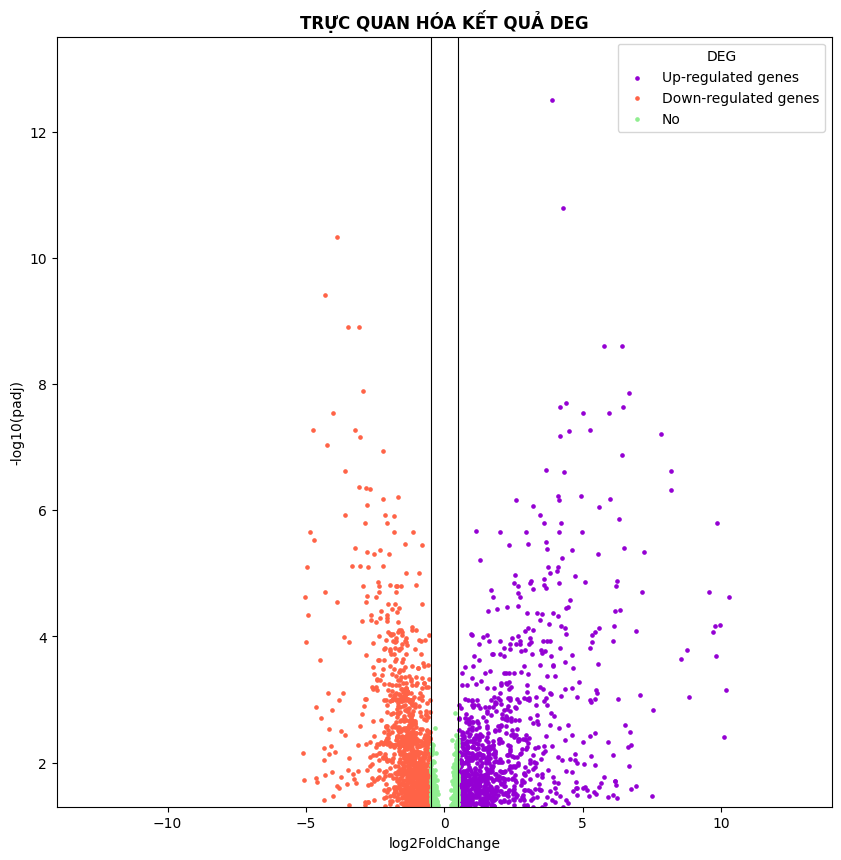

In [23]:
utils.vocanol_plot(df_result_DEA)

**CONCLUSION:** Out of a total of 2135 genes:
+ 993 genes are upregulated
+ 1142 genes are downregulated

# 4.IMMUNE ANALYSIS

**REMARKS:** Use the xCell algorithm to calculate immune scores and assess the tumor immune response:
+ Case 1: Keep all genes
+ Case 2: Select genes with log2FC > 2 from the DEA results
+ Analyze immune response at: [xCell](https://comphealth.ucsf.edu/app/xcell)

## 4.1.CASE 1

In [41]:
# SELECT LIST OF GENES
xcell_input_gene=df_gse91061_normalized.columns
# COVERT 'GENE ID' INTO 'GENE SYMBOL'
dict_gene_xcell=utils.gene_dict_id_symbol(xcell_input_gene)
dict_gene_xcell

Input sequence provided is already in string format. No operation performed


{'1': 'A1BG',
 '10': 'NAT2',
 '100': 'ADA',
 '1000': 'CDH2',
 '10000': 'AKT3',
 '100009676': 'ZBTB11-AS1',
 '10001': 'MED6',
 '10002': 'NR2E3',
 '10003': 'NAALAD2',
 '100033413': 'SNORD116-1',
 '100033414': 'SNORD116-2',
 '100033415': 'SNORD116-3',
 '100033417': 'SNORD116-5',
 '100033420': 'SNORD116-8',
 '100033422': 'SNORD116-10',
 '100033424': 'SNORD116-12',
 '100033425': 'SNORD116-13',
 '100033427': 'SNORD116-15',
 '100033428': 'SNORD116-16',
 '100033430': 'SNORD116-18',
 '100033431': 'SNORD116-20',
 '100033434': 'SNORD116-23',
 '100033435': 'SNORD116-24',
 '100033436': 'SNORD116-25',
 '100033438': 'SNORD116-26',
 '100033450': 'SNORD115-13',
 '100033820': 'SNORD116-28',
 '100033821': 'SNORD116-29',
 '100036567': 'SNORD115-47',
 '100037417': 'DDTL',
 '100038246': 'TLX1NB',
 '10004': 'NAALADL1',
 '100048912': 'CDKN2B-AS1',
 '100049076': 'GUSBP17',
 '100049587': 'SIGLEC14',
 '10005': 'ACOT8',
 '10006': 'ABI1',
 '10007': 'GNPDA1',
 '100073347': 'MIMT1',
 '10008': 'KCNE3',
 '10009': 'ZBT

In [42]:
# COVERT INDEX FROM 'GENE ID' INTO 'GENE SYMBOL'
df_xcell=df_gse91061_normalized.rename(dict_gene_xcell,axis=1)
# TRANPOSE DATAFRAME 
df_xcell=df_xcell.T
df_xcell

,Pt101_On_AD681975-5,Pt101_Pre_AD486328-5,Pt103_On_AE134059-6,Pt103_Pre_AE134058-2,Pt105_On_AE373241-6,Pt106_On_AD513626-6,Pt106_Pre_AD502250-5,Pt108_On_AE373243-6,Pt109_On_AE527955-5,Pt109_On_AE527955-6,...,Pt90_Pre_AD467873-6,Pt92_On_AE148750-5,Pt92_Pre_AE134060-5,Pt93_On_AE070988-5,Pt94_On_AE373242-6,Pt94_Pre_AD732850-6,Pt98_On_AE086717-6,Pt98_Pre_AD733586-8,Pt9_On_E9047644-7,Pt9_Pre_E9021024-6
A1BG,8.949981,9.023143,9.573336,10.779296,8.937731,9.017880,8.993183,9.216624,8.962497,8.856814,...,9.225968,8.982577,8.821508,8.963987,19.236138,9.109138,8.988242,9.062579,8.943428,8.888400
NAT2,4.827091,4.745642,4.746327,4.748063,4.745610,4.764431,4.787472,4.789188,4.746564,4.746203,...,4.745958,4.746185,4.746287,4.745357,18.782019,4.767667,4.745901,4.746107,4.900401,4.889257
ADA,10.285729,10.226275,7.570974,10.364105,9.428236,9.128837,9.209574,8.021938,8.613264,8.418825,...,9.508228,10.045471,9.417159,7.121161,8.506825,9.163653,8.657610,7.999846,8.404268,8.369369
CDH2,8.629851,7.846224,4.094638,5.963120,6.781157,10.872252,10.779973,9.301711,6.818714,6.312657,...,8.365443,8.991763,9.050899,6.146698,10.722709,7.685573,7.371841,7.784339,11.771848,11.511405
AKT3,11.380731,11.308811,12.478290,11.213758,12.223986,12.757052,12.698945,10.102231,11.155385,11.006544,...,11.988695,12.300655,12.379334,12.654630,11.892606,12.411115,12.586189,12.431851,12.565615,12.619806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTBP3,13.004016,12.934810,12.062423,11.597399,12.126886,11.549373,11.956301,11.882997,11.603701,11.555067,...,12.141332,12.373636,12.237407,12.788176,11.781885,12.077931,12.253268,11.980258,11.777977,11.903910
KCNE2,7.321257,7.332657,7.334513,7.307512,7.555249,7.358495,7.356234,7.452315,7.412057,7.386684,...,7.322647,7.340131,7.398554,7.369626,7.386278,7.355075,7.362215,7.349178,7.353816,7.387992
DGCR2,11.440785,11.454690,12.632570,11.333647,11.608289,11.362215,11.367981,11.328718,12.197865,12.041065,...,11.101001,11.619212,12.062451,11.460147,11.656451,11.521682,11.049034,11.309542,11.391955,11.286326
CASP8AP2,10.831259,10.860502,9.835034,8.826404,10.021762,9.433446,9.917718,9.689126,9.442596,9.595776,...,9.782242,10.467633,10.264261,9.961196,9.583739,9.856848,9.465097,9.465356,9.991407,10.070162


In [43]:
# LƯU FILE
df_xcell.to_csv('Preprocessed_data/xcell_all_genes.tsv',sep='\t')

## 4.2.CASE 2

In [44]:
# Lựa chọn các gene có log2FC > 2
xcell_input_gene=df_result_DEA[(df_result_DEA['log2FoldChange']>2)|(df_result_DEA['log2FoldChange']<-2)].index.to_list()
xcell_input_gene=list(map(str,xcell_input_gene))

In [45]:
# LỌC NHỮNG GENE CÓ TRONG TẬP GSE91061 ĐÃ CHUẨN HÓA
df_xcell_2=df_gse91061_normalized.loc[::,df_gse91061_normalized.columns.isin(xcell_input_gene)]
df_xcell_2

,10,100033413,100126299,100128054,100128285,100128675,100128682,100128946,100129027,100129271,...,9635,9699,9721,9723,973,9752,9890,9965,9971,9982
Pt101_On_AD681975-5,4.827091,-0.124352,-0.972332,0.295945,2.042398,4.389733,3.091473,-0.579807,0.086599,-1.468226,...,2.105527,5.200327,3.211298,4.240549,12.900364,0.035642,7.921808,-1.047710,6.502729,6.225442
Pt101_Pre_AD486328-5,4.745642,-0.123137,-0.971820,0.365806,3.243677,6.661508,2.400284,-0.872143,0.098268,-1.335364,...,0.396923,5.646775,1.923252,5.365736,13.140544,0.038354,7.250322,-1.033192,6.499537,6.225666
Pt103_On_AE134059-6,4.746327,0.470071,-0.470765,0.441587,3.935664,4.516442,8.614415,-1.106330,0.111997,7.658405,...,9.664670,8.219506,6.051357,5.391358,5.115398,0.041640,8.772583,-0.423557,6.494790,7.203824
Pt103_Pre_AE134058-2,4.748063,-0.117971,-0.198775,2.500808,1.873939,2.395469,6.283002,-1.102580,0.143373,9.660030,...,8.104240,7.027517,6.839214,5.181088,10.754654,0.049545,7.369914,-0.938471,6.495383,7.434130
Pt105_On_AE373241-6,4.745610,0.176346,-0.971849,7.535547,4.619885,3.042411,9.072082,-1.107730,0.485948,-1.342513,...,1.659580,5.542109,-0.132513,3.372215,8.276450,0.038198,12.169791,-1.034489,6.509348,6.225653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,4.767667,-0.120968,-0.970217,0.473022,3.188851,1.543802,6.644080,-0.590192,0.118024,-1.140964,...,3.539868,4.683880,0.719763,2.607997,8.173577,0.043116,8.452517,-0.997841,6.758828,6.226072
Pt98_On_AE086717-6,4.745901,0.197222,-0.309787,7.869255,3.412781,4.563389,9.793192,-1.107464,1.155369,-1.280102,...,3.086088,4.667230,-0.111780,3.205372,5.780895,0.039607,5.701945,-1.023158,7.244735,6.225771
Pt98_Pre_AD733586-8,4.746107,-0.122121,-0.577891,7.854411,2.925345,3.734087,9.705544,-1.106901,1.714682,1.171905,...,3.599744,4.609013,-0.097672,5.164645,4.294059,0.040596,3.556506,-0.445474,6.970040,6.225855
Pt9_On_E9047644-7,4.900401,1.040166,-0.972245,0.969685,5.435165,3.653457,1.909787,-1.108030,0.878807,-1.443957,...,2.704836,8.012246,3.723955,4.700475,4.095173,1.303401,8.337194,-0.547868,6.494401,6.225480


In [46]:
# TẠO DICT GENE ID: GENE SYMBOL
dict_gene_xcell_2=utils.gene_dict_id_symbol(df_xcell_2.columns)

Input sequence provided is already in string format. No operation performed


In [47]:
# ĐỔI TÊN COLUMN (TỪ GENE ID SANG GENE SYMBOL)
df_xcell_2.rename(dict_gene_xcell_2,axis=1,inplace=True)
df_xcell_2

,NAT2,SNORD116-1,VTRNA2-1,PLCE1-AS1,DNM1P35,HPN-AS1,LINC01531,LINC01310,PCBP3-AS1,KPLCE,...,CLCA2,RIMS2,GPRIN2,SEMA3E,CD79A,PCDHA9,PLPPR4,FGF19,NR1H4,FGFBP1
Pt101_On_AD681975-5,4.827091,-0.124352,-0.972332,0.295945,2.042398,4.389733,3.091473,-0.579807,0.086599,-1.468226,...,2.105527,5.200327,3.211298,4.240549,12.900364,0.035642,7.921808,-1.047710,6.502729,6.225442
Pt101_Pre_AD486328-5,4.745642,-0.123137,-0.971820,0.365806,3.243677,6.661508,2.400284,-0.872143,0.098268,-1.335364,...,0.396923,5.646775,1.923252,5.365736,13.140544,0.038354,7.250322,-1.033192,6.499537,6.225666
Pt103_On_AE134059-6,4.746327,0.470071,-0.470765,0.441587,3.935664,4.516442,8.614415,-1.106330,0.111997,7.658405,...,9.664670,8.219506,6.051357,5.391358,5.115398,0.041640,8.772583,-0.423557,6.494790,7.203824
Pt103_Pre_AE134058-2,4.748063,-0.117971,-0.198775,2.500808,1.873939,2.395469,6.283002,-1.102580,0.143373,9.660030,...,8.104240,7.027517,6.839214,5.181088,10.754654,0.049545,7.369914,-0.938471,6.495383,7.434130
Pt105_On_AE373241-6,4.745610,0.176346,-0.971849,7.535547,4.619885,3.042411,9.072082,-1.107730,0.485948,-1.342513,...,1.659580,5.542109,-0.132513,3.372215,8.276450,0.038198,12.169791,-1.034489,6.509348,6.225653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,4.767667,-0.120968,-0.970217,0.473022,3.188851,1.543802,6.644080,-0.590192,0.118024,-1.140964,...,3.539868,4.683880,0.719763,2.607997,8.173577,0.043116,8.452517,-0.997841,6.758828,6.226072
Pt98_On_AE086717-6,4.745901,0.197222,-0.309787,7.869255,3.412781,4.563389,9.793192,-1.107464,1.155369,-1.280102,...,3.086088,4.667230,-0.111780,3.205372,5.780895,0.039607,5.701945,-1.023158,7.244735,6.225771
Pt98_Pre_AD733586-8,4.746107,-0.122121,-0.577891,7.854411,2.925345,3.734087,9.705544,-1.106901,1.714682,1.171905,...,3.599744,4.609013,-0.097672,5.164645,4.294059,0.040596,3.556506,-0.445474,6.970040,6.225855
Pt9_On_E9047644-7,4.900401,1.040166,-0.972245,0.969685,5.435165,3.653457,1.909787,-1.108030,0.878807,-1.443957,...,2.704836,8.012246,3.723955,4.700475,4.095173,1.303401,8.337194,-0.547868,6.494401,6.225480


In [48]:
# TRANPOSE DATAFRAME
df_xcell_2=df_xcell_2.T
df_xcell_2

,Pt101_On_AD681975-5,Pt101_Pre_AD486328-5,Pt103_On_AE134059-6,Pt103_Pre_AE134058-2,Pt105_On_AE373241-6,Pt106_On_AD513626-6,Pt106_Pre_AD502250-5,Pt108_On_AE373243-6,Pt109_On_AE527955-5,Pt109_On_AE527955-6,...,Pt90_Pre_AD467873-6,Pt92_On_AE148750-5,Pt92_Pre_AE134060-5,Pt93_On_AE070988-5,Pt94_On_AE373242-6,Pt94_Pre_AD732850-6,Pt98_On_AE086717-6,Pt98_Pre_AD733586-8,Pt9_On_E9047644-7,Pt9_Pre_E9021024-6
NAT2,4.827091,4.745642,4.746327,4.748063,4.745610,4.764431,4.787472,4.789188,4.746564,4.746203,...,4.745958,4.746185,4.746287,4.745357,18.782019,4.767667,4.745901,4.746107,4.900401,4.889257
SNORD116-1,-0.124352,-0.123137,0.470071,-0.117971,0.176346,-0.122183,-0.124151,-0.120867,-0.121136,-0.121915,...,0.201272,0.455502,0.069898,0.268115,-0.119182,-0.120968,0.197222,-0.122121,1.040166,0.390220
VTRNA2-1,-0.972332,-0.971820,-0.470765,-0.198775,-0.971849,-0.971417,-0.972248,-0.970100,-0.794940,-0.971304,...,-0.971528,-0.192229,-0.971129,-0.972084,-0.964425,-0.970217,-0.309787,-0.577891,-0.972245,-0.971881
PLCE1-AS1,0.295945,0.365806,0.441587,2.500808,7.535547,5.924417,5.853939,0.477589,3.988686,3.847228,...,5.770143,0.426661,1.177013,0.330829,2.150478,0.473022,7.869255,7.854411,0.969685,2.748220
DNM1P35,2.042398,3.243677,3.935664,1.873939,4.619885,2.728780,2.727930,4.565677,4.839234,4.493271,...,3.056045,4.153517,5.158625,5.623147,1.838485,3.188851,3.412781,2.925345,5.435165,5.822335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCDHA9,0.035642,0.038354,0.041640,0.049545,0.038198,0.040459,0.036093,0.043336,0.042751,0.281193,...,0.572071,0.878451,0.809879,0.036960,0.046968,0.043116,0.039607,0.040596,1.303401,1.414803
PLPPR4,7.921808,7.250322,8.772583,7.369914,12.169791,7.751754,8.811511,5.907299,7.130797,6.944768,...,6.321012,7.527837,7.277125,13.945637,8.109603,8.452517,5.701945,3.556506,8.337194,8.641846
FGF19,-1.047710,-1.033192,-0.423557,-0.938471,-1.034489,-1.016653,-1.045498,2.367337,-1.000308,-1.012297,...,-1.021024,-1.012921,-1.009384,8.998002,-0.973748,-0.997841,-1.023158,-0.445474,-0.547868,-1.035885
NR1H4,6.502729,6.499537,6.494790,6.495383,6.509348,6.556490,6.563388,6.494914,6.501194,6.512139,...,6.527313,6.535138,6.494777,6.494459,16.688342,6.758828,7.244735,6.970040,6.494401,6.494534


In [49]:
df_xcell_2.to_csv('Preprocessed_data/xcell_log2FC_greater_2.tsv',sep='\t')

## 4.3.READ AND ANALYZE XCELL RESULTS

+ NOTE: DUE TO LACK OF DATA, CASE 2 DATA COULD NOT BE ANALYZED BY XCELL
+  *.txt",  Raw enrichment scores:
+ *RAW.txt, P-values for the significance of the scores to be different from zero:
+ *pvals.txt.  In the manuscript we use a threshold of 0.2 to detemine a significant score.

In [52]:
df_immuno_results=pd.read_csv('xcell_results/xCell_xcell_all_genes_xCell_1221112925.txt',delimiter='\t',index_col=0)
df_immuno_results

,Pt101_On_AD681975.5,Pt101_Pre_AD486328.5,Pt103_On_AE134059.6,Pt103_Pre_AE134058.2,Pt105_On_AE373241.6,Pt106_On_AD513626.6,Pt106_Pre_AD502250.5,Pt108_On_AE373243.6,Pt109_On_AE527955.5,Pt109_On_AE527955.6,...,Pt90_Pre_AD467873.6,Pt92_On_AE148750.5,Pt92_Pre_AE134060.5,Pt93_On_AE070988.5,Pt94_On_AE373242.6,Pt94_Pre_AD732850.6,Pt98_On_AE086717.6,Pt98_Pre_AD733586.8,Pt9_On_E9047644.7,Pt9_Pre_E9021024.6
Adipocytes,0.0419,0.0193,0.0610,0.0226,0.0178,0.1178,0.0957,0.0276,0.0497,0.0191,...,0.0155,0.0000,0.0225,0.0164,0.1756,0.0967,0.0000,0.0000,0.0686,0.1510
Astrocytes,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0641,0.0501
B-cells,0.5711,0.6699,0.0181,0.1090,0.1332,0.0621,0.0853,0.0418,0.1022,0.1051,...,0.0480,0.1701,0.1222,0.0332,0.0434,0.1182,0.1247,0.0886,0.0240,0.0363
Basophils,0.0721,0.0634,0.0000,0.3019,0.1416,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.1118,0.2233,0.1089,0.0133,0.0295,0.0000,0.0148,0.0000,0.0000,0.0000
CD4+ T-cells,0.4075,0.3719,0.0000,0.0329,0.0936,0.0000,0.0000,0.0741,0.0797,0.0870,...,0.0209,0.2246,0.0780,0.0000,0.0000,0.0518,0.0520,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pDC,0.3054,0.3260,0.0000,0.0986,0.1557,0.0450,0.0516,0.1815,0.0936,0.0862,...,0.0744,0.2228,0.0967,0.0480,0.1375,0.0405,0.0842,0.0428,0.0000,0.0034
pro B-cells,0.1357,0.1741,0.0000,0.0000,0.1441,0.0350,0.0347,0.0000,0.0954,0.1076,...,0.0081,0.0939,0.0572,0.0589,0.0290,0.0057,0.0168,0.0261,0.0132,0.0000
ImmuneScore,1.1744,1.2190,0.2201,0.7022,0.6356,0.2794,0.3148,0.5635,0.5276,0.4885,...,0.4928,0.9523,0.5475,0.1674,0.3526,0.4067,0.5583,0.3137,0.1996,0.2415
StromaScore,0.1982,0.0669,0.1805,0.2015,0.1266,0.2406,0.3058,0.2178,0.2396,0.2106,...,0.0400,0.1595,0.2288,0.1608,0.1804,0.2463,0.1184,0.0942,0.2513,0.3133


In [50]:
df_immuno_raw=pd.read_csv('xcell_results/xCell_xcell_all_genes_xCell_1221112925_RAW.txt',delimiter='\t',index_col=0)
df_immuno_raw

,Pt101_On_AD681975.5,Pt101_Pre_AD486328.5,Pt103_On_AE134059.6,Pt103_Pre_AE134058.2,Pt105_On_AE373241.6,Pt106_On_AD513626.6,Pt106_Pre_AD502250.5,Pt108_On_AE373243.6,Pt109_On_AE527955.5,Pt109_On_AE527955.6,...,Pt90_Pre_AD467873.6,Pt92_On_AE148750.5,Pt92_Pre_AE134060.5,Pt93_On_AE070988.5,Pt94_On_AE373242.6,Pt94_Pre_AD732850.6,Pt98_On_AE086717.6,Pt98_Pre_AD733586.8,Pt9_On_E9047644.7,Pt9_Pre_E9021024.6
Adipocytes,821.397765,617.190138,987.392380,867.415936,710.302114,1471.264122,1227.373287,561.930865,772.152504,521.447783,...,555.943313,509.735893,613.771921,551.667968,2870.052995,1284.224717,508.770124,455.206242,927.531388,1554.334104
Astrocytes,801.098746,533.070093,991.876576,1745.908017,679.993762,1255.807964,1482.859847,1382.342997,810.936595,773.857148,...,907.393489,750.156945,1060.425788,951.724686,1119.983544,1226.480287,515.784921,455.792814,1840.255058,1816.236866
B-cells,3574.572058,4057.783942,357.032033,1164.728597,940.440086,467.012533,586.854365,506.276800,614.126509,621.598817,...,567.388847,1271.983372,861.059216,238.015678,368.741893,742.932374,848.573705,612.124153,252.924048,290.020446
Basophils,649.962101,665.494647,427.011909,936.271220,709.126900,384.545038,351.403074,292.754680,276.935679,270.010908,...,667.087734,772.180103,583.128270,407.537573,429.719004,405.507991,467.087182,393.317992,226.128721,235.748242
CD4+ T-cells,2151.082133,2103.916662,240.548740,537.495080,882.659233,313.417282,392.882960,438.858144,439.210919,445.895101,...,470.206503,1316.100811,634.409875,287.569324,189.869587,586.386361,530.835632,250.671216,293.581561,287.872400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ly Endothelial cells,1746.595350,1050.644609,945.814516,1336.790959,725.477476,996.402348,1279.637694,1077.085922,979.986833,783.259415,...,576.130594,1082.752430,1269.471327,1407.846862,962.836203,1918.069076,465.179838,561.228167,1047.082305,1082.816061
mv Endothelial cells,1156.753113,827.082102,757.581698,1054.707031,644.278047,816.478982,911.610234,704.681311,818.734339,695.472077,...,460.764984,783.767039,922.683255,722.934362,634.725377,1199.841084,500.865437,575.790621,740.909189,838.244812
naive B-cells,3451.181088,3896.048274,427.795796,904.418558,756.973312,426.278273,431.047553,438.133497,516.264395,536.296430,...,524.405855,1124.288629,736.866243,302.970181,240.042314,686.152757,656.127164,537.316280,189.592783,204.312788
pDC,2498.808761,2549.772572,440.406285,1341.141454,1389.650202,680.852835,722.882041,1592.567932,791.675615,723.495875,...,953.386378,1823.033779,991.906075,552.877908,1136.505998,651.497537,957.145298,629.201482,186.810158,258.453156


In [51]:
df_immuno_pvals=pd.read_csv('xcell_results/xCell_xcell_all_genes_xCell_1221112925.pvals.txt',delimiter='\t',index_col=0)
df_immuno_pvals

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105
Adipocytes,0.002687,0.231560,0.000000,0.155097,0.271350,0.000000,0.000000,0.070430,0.00000,0.236677,...,0.338320,1.000000,0.157257,0.310963,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000
Astrocytes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.021260,0.06229
B-cells,0.000000,0.000000,0.295303,0.000000,0.000000,0.010890,0.000137,0.047717,0.00000,0.000000,...,0.028953,0.000000,0.000000,0.099463,0.041583,0.000000,0.000000,0.000000,0.200107,0.07700
Basophils,0.257673,0.289943,1.000000,0.002810,0.129310,1.000000,1.000000,1.000000,1.00000,1.000000,...,0.168600,0.044980,0.173180,0.684237,0.504327,1.000000,0.663967,1.000000,1.000000,1.00000
CD4+ T-cells,0.000000,0.000000,1.000000,0.554543,0.176193,1.000000,1.000000,0.297247,0.26141,0.215730,...,0.610313,0.000000,0.272147,1.000000,1.000000,0.443500,0.442173,1.000000,1.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ly Endothelial cells,0.000000,0.000000,0.129340,0.046110,1.000000,0.317290,0.000000,0.000000,0.00000,0.146927,...,1.000000,0.000000,0.000000,0.000000,0.076457,0.000000,1.000000,1.000000,0.000000,0.00000
mv Endothelial cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.507683,0.000000,0.000000,0.00000
naive B-cells,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,0.017997,0.039983,1.000000,1.000000,0.112163,0.071187,0.193263,1.000000,1.00000
pDC,0.000000,0.000000,1.000000,0.000000,0.000000,0.088087,0.056673,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.071363,0.000000,0.122940,0.000000,0.103887,1.000000,0.82360


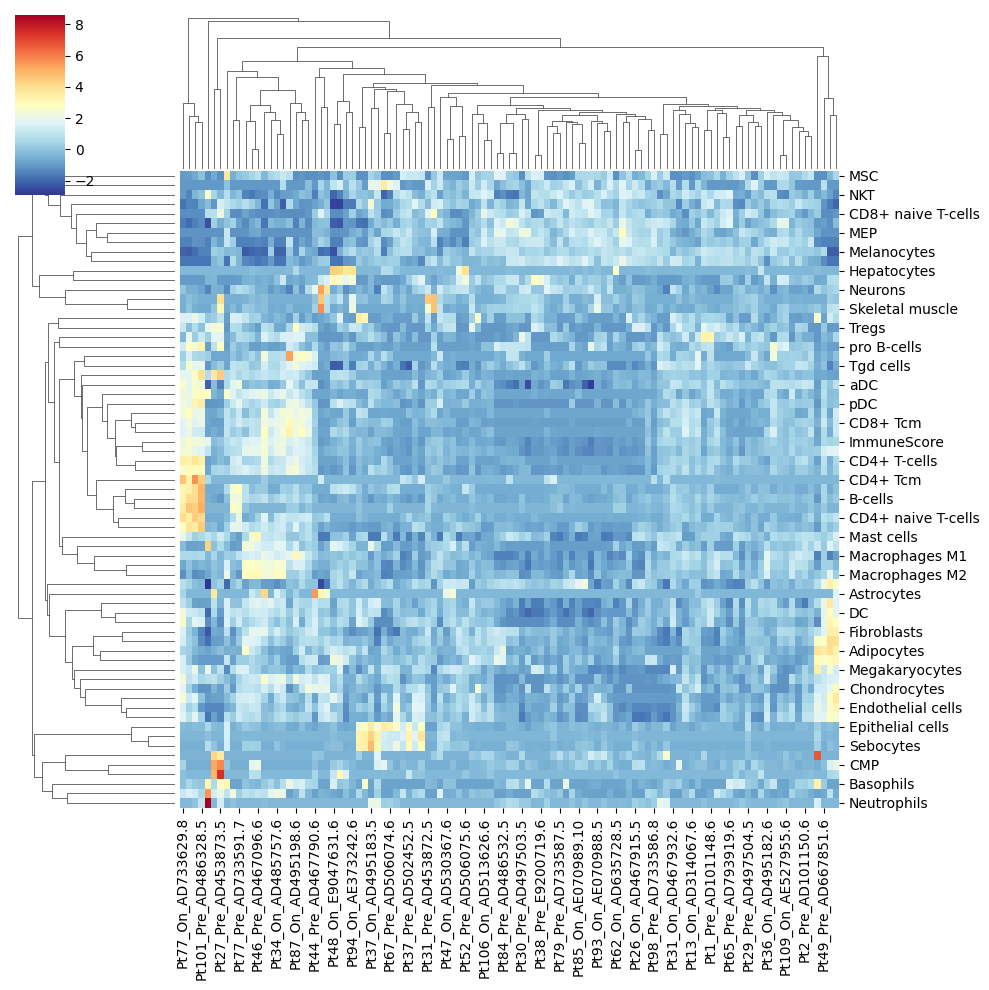

In [53]:
sns.clustermap(df_immuno_results,z_score=0,cmap='RdYlBu_r')
plt.show()

# 5.GENE ONTOLOGY ENRICHMENT ANALYSIS

**NHẬN XÉT:** gseapy library to identify the function of upregulated và downregulated genes:
+ Biological processes (BP)
+ Mocular function (MF)
+ Cellular components (CC)

## 5.1.UP REGULATED GENES

In [55]:
# Dictionary gene id: gene symbol
dict_upregulated_genes=utils.gene_dict_id_symbol(list_upregulated_genes_id)
list_upregulated_genes_symbol=list(dict_upregulated_genes.values())
list_upregulated_genes_symbol

Input sequence provided is already in string format. No operation performed


['C8orf88',
 'PLCE1-AS1',
 'DNM1P35',
 'HPN-AS1',
 'LINC01531',
 'PCBP3-AS1',
 'KPLCE',
 'FAM83F',
 'CYKILR',
 'LINC00930',
 'TPT1-AS1',
 'CDH4',
 'LCDR',
 'LOC100287036',
 'RASAL2-AS1',
 'LOC100335030',
 'ZNF225-AS1',
 'LINC00673',
 'MIR3671',
 'CCDC179',
 'OSER1-DT',
 'SH3PXD2A-AS1',
 'APTR',
 'LINC00920',
 'LINC01093',
 'LOC100506274',
 'INKA2-AS1',
 'CBR3-AS1',
 'LINC00648',
 'MISFA',
 'PXN-AS1',
 'LINC00327',
 'PRKG1-AS1',
 'TMCC1-DT',
 'CHASERR',
 'ZNF571-AS1',
 'LINC01606',
 'AP1M2',
 'SEC24B-AS1',
 'ABCC5',
 'CEP295NL',
 'KLHL7-DT',
 'GDNF-AS1',
 'CLDN10-AS1',
 'ST3GAL6-AS1',
 'KCNK7',
 'CDH15',
 'YTHDF3-DT',
 'DHRS2',
 'CDK6',
 'GDF11',
 'TRIB1',
 'IRX5',
 'CORO2B',
 'NDRG1',
 'ADARB1',
 'ST3GAL6',
 'CDSN',
 'LYPLA1',
 'CEACAM5',
 'AGR2',
 'SLCO1B1',
 'ST6GALNAC2',
 'POLR3F',
 'IGF2BP2',
 'CSPG5',
 'CERS1',
 'NES',
 'GJB6',
 'FTCD',
 'AP3M2',
 'MLLT11',
 'KCNQ1OT1',
 'COPS5',
 'SPINK5',
 'KLK11',
 'STON1',
 'HSF2BP',
 'SPACA9',
 'IL1RAPL1',
 'LDB3',
 'PTP4A3',
 'PKP3',
 'WIF1'

In [56]:
list_upregulated_genes_symbol = [
    g for g in list_upregulated_genes_symbol
    if isinstance(g, str) and g.strip() != ''
]

In [60]:
# GO enrichment analysis
enr_up=gseapy.enrichr(gene_list=list_upregulated_genes_symbol,
                      gene_sets=['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021'],
                      outdir=None,
                      background=None,
                      organism='human')

In [61]:
result_GO_up_gene=enr_up.results
result_GO_up_gene

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,epidermis development (GO:0008544),30/83,1.257913e-18,3.719648e-15,0,0,11.177476,460.702915,COL17A1;SPRR2E;SPRR2G;CALML5;KLK5;EVPL;KLK7;NT...
1,GO_Biological_Process_2021,skin development (GO:0043588),24/80,4.069262e-13,6.016404e-10,0,0,8.409051,239.911429,CERS3;FLG;SPRR2G;CDSN;ITGA3;PDGFA;KRT10;ABCA12...
2,GO_Biological_Process_2021,epidermal cell differentiation (GO:0009913),18/53,3.411611e-11,2.729992e-08,0,0,10.039683,241.968912,CERS3;FLG;SPRR2G;CDSN;SPINK5;KRT10;OVOL1;EVPL;...
3,GO_Biological_Process_2021,keratinocyte differentiation (GO:0030216),16/41,3.692922e-11,2.729992e-08,0,0,12.474743,299.668510,FLG;CERS3;SPRR2G;CDSN;KRT10;EVPL;EREG;SCEL;KRT...
4,GO_Biological_Process_2021,peptide cross-linking (GO:0018149),13/31,8.892443e-10,5.258991e-07,0,0,14.039349,292.589157,FLG;SPRR2E;KRT2;KRT1;KRT10;EVPL;LORICRIN;PI3;T...
...,...,...,...,...,...,...,...,...,...,...
3882,GO_Molecular_Function_2021,RNA polymerase II-specific DNA-binding transcr...,3/190,9.962550e-01,9.999940e-01,0,0,0.305951,0.001148,NHLH2;SDR16C5;PITX1
3883,GO_Molecular_Function_2021,nuclear receptor binding (GO:0016922),1/120,9.977784e-01,9.999940e-01,0,0,0.160514,0.000357,DCAF13
3884,GO_Molecular_Function_2021,ubiquitin-protein transferase activity (GO:000...,8/392,9.991348e-01,9.999940e-01,0,0,0.395154,0.000342,TRIM9;TRIM51;TRIM2;RNF39;TRIM58;NCCRP1;FBXO7;T...
3885,GO_Molecular_Function_2021,guanyl-nucleotide exchange factor activity (GO...,1/149,9.994932e-01,9.999940e-01,0,0,0.128863,0.000065,EPS8L1


<Axes: title={'center': 'GO FOR UP-REGULATED GENES'}, xlabel='Gene_set'>

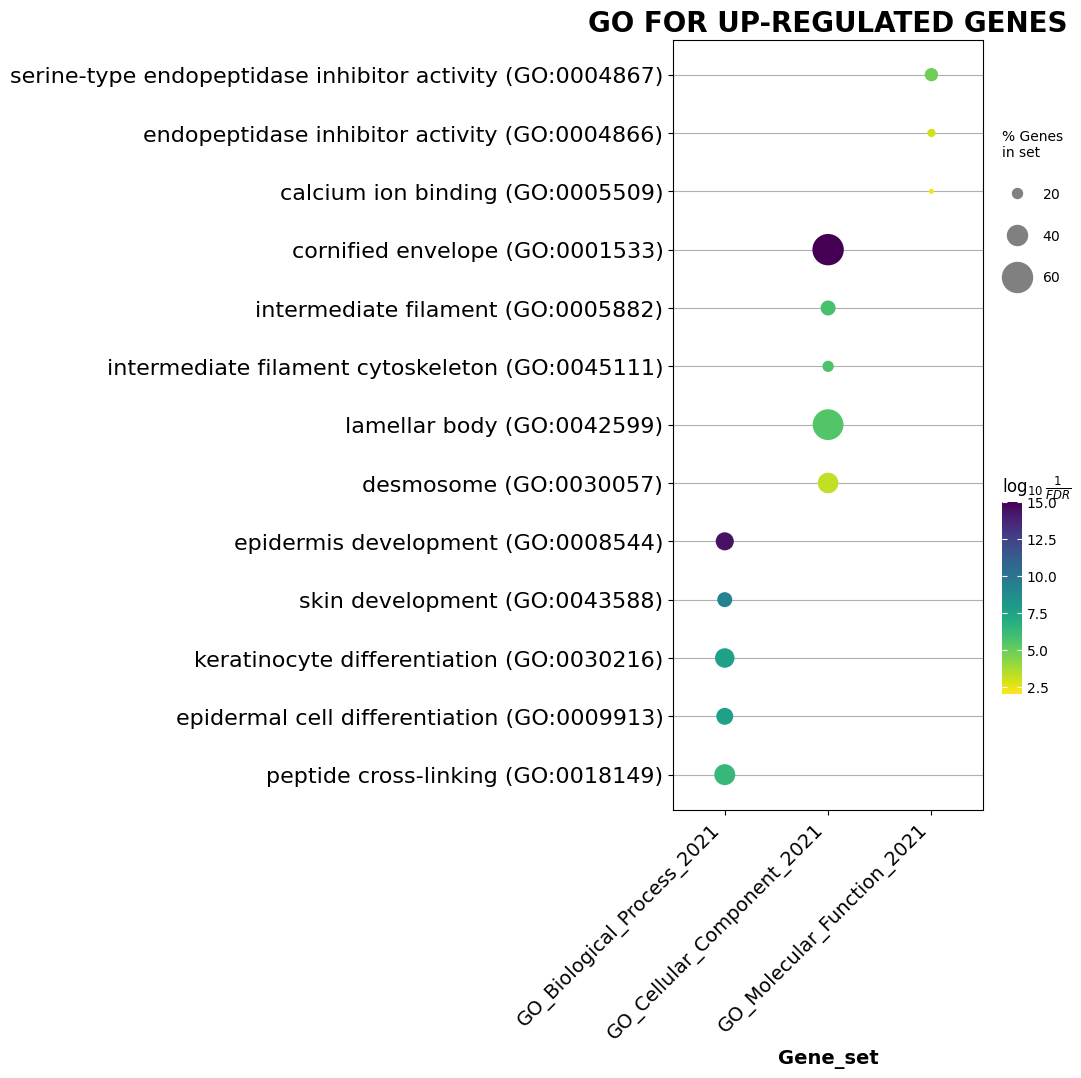

In [62]:
gseapy.dotplot(df=result_GO_up_gene,
               column='Adjusted P-value',
               size=6,
               top_term=5,
               figsize=(5,10),
               title='GO FOR UP-REGULATED GENES',
               cmap='viridis_r',
               x='Gene_set',
               xticklabels_rot=45)

## 5.2.DOWN REGUALATED GENES

In [64]:
# Dictionary gene id: gene symbol
dict_downregulated_genes=utils.gene_dict_id_symbol(list_downregulated_genes_id)
list_downregulated_genes_symbol=list(dict_downregulated_genes.values())
list_downregulated_genes_symbol

Input sequence provided is already in string format. No operation performed


['NAT2',
 'SIGLEC14',
 'BCAR3-AS1',
 'CCDC152',
 'LINC00861',
 'LOC100130298',
 'LINC02881',
 'LOC100130872',
 'USP30-AS1',
 'CLUHP3',
 'LINC01119',
 'GNE',
 'PCED1B-AS1',
 'MEF2B',
 'C4B_2',
 'CDH5',
 'LINC00578',
 'LNROP',
 'LINC01599',
 'PTPRN2-AS1',
 'TRG-AS1',
 'TSPOAP1-AS1',
 'ECE1-AS1',
 'TPBGL',
 'LRCOL1',
 'ABCC9',
 'NR1H3',
 'DNM3OS',
 'KIAA2012',
 'SGK2',
 'ARL4C',
 'RASGRP1',
 'CDH17',
 'RASA4',
 'LPCAT3',
 'CHST4',
 'PRG4',
 'GPA33',
 'CD96',
 'RASGRP2',
 'IGSF6',
 'RGS19',
 'IKZF1',
 'SIRPB1',
 'CLEC4M',
 'CDO1',
 'BASP1',
 'CD52',
 'ACAA2',
 'ZBTB18',
 'CEBPA',
 'SEMA4D',
 'SH2B2',
 'ARID3B',
 'CXCR6',
 'CD226',
 'CLDN16',
 'CETP',
 'GRAP',
 'IQGAP2',
 'HPSE',
 'LILRB1',
 'CFHR3',
 'CEACAM4',
 'LYVE1',
 'EHD1',
 'SDS',
 'SLC27A2',
 'LILRA2',
 'PIM2',
 'ADAMTS5',
 'ADCY5',
 'CORO1A',
 'MAP4K1',
 'INMT',
 'ANXA10',
 'SP140',
 'TUBA3E',
 'STX1B',
 'KLF12',
 'ADCY7',
 'SLCO2B1',
 'CD300A',
 'ACKR5',
 'SLC46A1',
 'VSIG4',
 'CHRNA1',
 'PIK3IP1',
 'NLRP3',
 'GALNT13',
 'SLAMF6'

In [65]:
# GO enrichment analysis 
enr=gseapy.enrichr(gene_list=list_downregulated_genes_symbol,
                   gene_sets=['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021'],
                   outdir=None,
                   background=None,organism='human')

In [66]:
result_GO_down_gene=enr.results
result_GO_down_gene

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,antigen receptor-mediated signaling pathway (G...,54/185,3.192978e-24,1.199282e-20,0,0,7.102060,384.229161,ITK;CD3G;PTPN22;SLA2;CD3E;CD3D;ZC3H12A;BLNK;IC...
1,GO_Biological_Process_2021,regulation of immune response (GO:0050776),49/179,9.180154e-21,1.724033e-17,0,0,6.464645,298.260896,CD40;ITGB2;ICAM2;ICAM3;CD3G;PTPN22;TREM2;SLA2;...
2,GO_Biological_Process_2021,positive regulation of cytokine production (GO...,62/335,1.303673e-16,1.632198e-13,0,0,3.911952,143.084249,CD86;ITK;CD40;ORM1;FLT4;IL27;RORA;PTPN22;TNF;P...
3,GO_Biological_Process_2021,cytokine-mediated signaling pathway (GO:0019221),89/621,6.477155e-16,6.082048e-13,0,0,2.914433,101.926685,CD86;CSF3;CIITA;CD40;SPI1;TNFRSF13B;FLT3;ITGB2...
4,GO_Biological_Process_2021,T cell activation (GO:0042110),30/92,1.635388e-15,1.228504e-12,0,0,8.186609,278.728627,ITK;CD3G;PTPN22;NLRC3;CD3E;SLA2;CD1C;RASGRP1;P...
...,...,...,...,...,...,...,...,...,...,...
4713,GO_Molecular_Function_2021,tubulin binding (GO:0015631),9/307,9.923961e-01,9.971949e-01,0,0,0.495201,0.003780,ARL4C;SUN2;CCDC69;CCDC88C;VASH2;RMDN3;IRAG2;KI...
4714,GO_Molecular_Function_2021,calcium channel activity (GO:0005262),1/84,9.928781e-01,9.971949e-01,0,0,0.198436,0.001418,PKD1L3
4715,GO_Molecular_Function_2021,ubiquitin-protein transferase activity (GO:000...,9/392,9.996867e-01,9.999938e-01,0,0,0.383535,0.000120,NEURL1B;ZNRF2;FBXO2;SYVN1;TRIM14;DTX1;TNFAIP3;...
4716,GO_Molecular_Function_2021,cadherin binding (GO:0045296),6/322,9.998280e-01,9.999938e-01,0,0,0.310205,0.000053,EHD1;CNN2;CDH5;CAPG;CDH17;EGFR


<Axes: title={'center': 'GO FOR DOWN-REGULATED GENES'}, xlabel='Gene_set'>

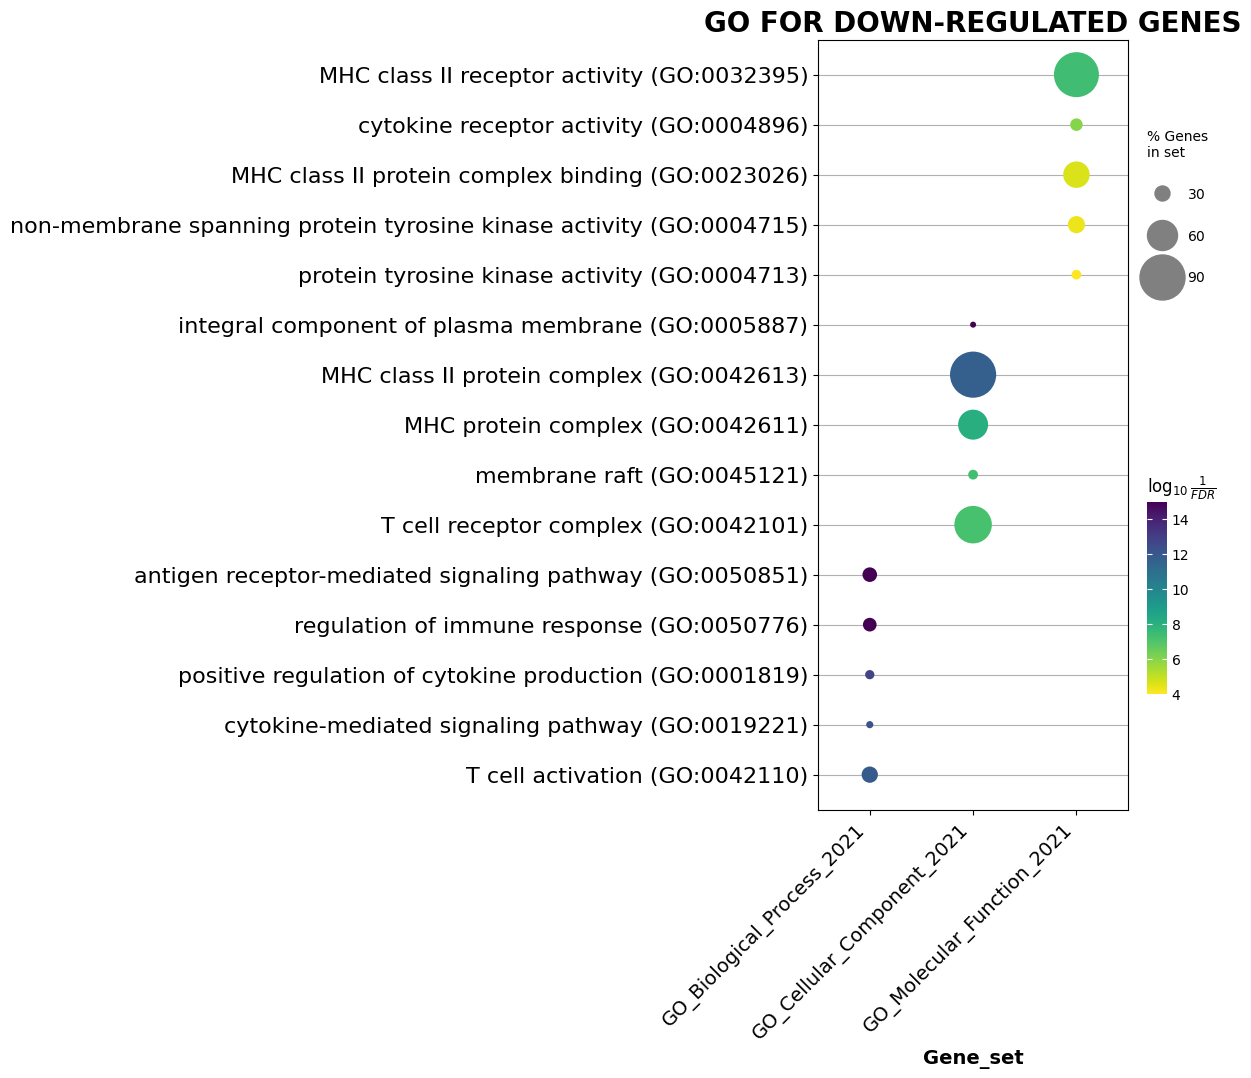

In [67]:
gseapy.dotplot(df=result_GO_down_gene,
               column='Adjusted P-value',
               size=6,
               top_term=5,
               figsize=(5,10),
               title='GO FOR DOWN-REGULATED GENES',
               cmap='viridis_r',
               x='Gene_set',
               xticklabels_rot=45)

# 6.SVM-RFE

**NOTE:** Use the `SVM-RFE model` to identify the `top 4 upregulated genes`, `top 4 downregulated genes`, and the `top 100 genes related to ICI response` (Feature Importances).

## 6.1.TRAIN SVM-RFE MODEL

**NOTE:** In this step, `Suport Vector Machine` coupled with `Recursive Feature Elimination` are used to select `top 4 up-regulated genes`, `top 4 down-regulated genes`, and `top 100 over-expressed genes`:
+ Define `SVC` model with `linear` as default kernel
+ Tune hyperparameters to select the best SVC model
+ Apply RFE to select the most important features (top genes)

In [43]:
def important_gene_by_SVM_RFE(list_genes:list,n_feature_importance:int,df_normalized_count:pd.DataFrame,df_meta:pd.DataFrame)->list:
    # COVERT STRING TYPE INTO INTEGER ONE:
    list_genes=list(map(str,list_genes))
    # ASIGN INPUT
    X_train=df_normalized_count.loc[::,list_genes]
    # ASIGN OUTPUT
    y_train=df_meta['New_conditions_encoded']
    # CREATE HYPERPARAMETER GRID
    grid={
        'C':range(1,100),
        'gamma':['scale', 'auto', 0.01, 0.001],
        'degree':range(1,10)
    }
    # DEFINE SVC MODEL
    model=SVC(random_state=42,kernel='linear')
    # TUNING SVC MODEL
    random_searcher=RandomizedSearchCV(estimator=model,scoring='accuracy',param_distributions=grid,cv=10,random_state=42)
    # SELECT THE BEST SVC MODEL
    random_searcher.fit(X=X_train,y=y_train)
    SCV_model=random_searcher.best_estimator_
    # FEATURE IMPORTANCE WITH RFE
    rfe=RFE(estimator=SCV_model,n_features_to_select=n_feature_importance,step=1)
    rfe.fit(X=X_train,y=y_train)
    # SELECT IMPORT GENES
    selected_genes=X_train.columns[rfe.support_]
    return list(selected_genes)

In [32]:
# SELECT TOP 4 UPREGULATED GENES
top_4_up_genes=important_gene_by_SVM_RFE(list_upregulated_genes_id,4,df_gse91061_normalized,df_meta_GSE91061)

In [33]:
# SELECT TOP 4 DOWNREGULATED GENES
top_4_down_genes=important_gene_by_SVM_RFE(list_downregulated_genes_id,4,df_gse91061_normalized,df_meta_GSE91061)

In [34]:
# SELECT TOP 100 UPREGULATED VÀ DOWNREGULATED GENES
top_100_genes=important_gene_by_SVM_RFE(list_up_down_genes_id,100,df_gse91061_normalized,df_meta_GSE91061)

## 6.2.SAVE LIST GENES 

`Note`: Lists of selected genes are saved in pkl files for further analysis 

In [35]:
# SAVE
def save(path,Object):
    with open(path,mode='wb') as f:
        pickle.dump(Object,f)
    print('Complete')

In [36]:
save('Top_genes_SVM_RFE/top_4_up_genes.pkl',top_4_up_genes)
save('Top_genes_SVM_RFE/top_4_down_genes.pkl',top_4_down_genes)
save('Top_genes_SVM_RFE/top_100_genes.pkl',top_100_genes)

Complete
Complete
Complete


## 6.3.READ LIST GENES

`Note`: Read Lists of selected genes saved in pkl files

In [37]:
# READ FILE
def read(path):
    with open(path,mode='rb') as f:
        list_genes=pickle.load(f)
    return list_genes

In [38]:
top_4_up=read('Top_genes_SVM_RFE/top_4_up_genes.pkl')
top_4_down=read('Top_genes_SVM_RFE/top_4_down_genes.pkl')
top_100=read('Top_genes_SVM_RFE/top_100_genes.pkl')

## 6.4.RESULTS

In [47]:
dict_top_4_up=utils.gene_dict_id_symbol(top_4_up)
print(f'Top 4 genes upregulated include:\n{dict_top_4_up.values()}')

Input sequence provided is already in string format. No operation performed


Top 4 genes upregulated include:
dict_values(['DDIT4L', 'MCHR1', 'SLC9A3', 'H4C8'])


In [48]:
dict_top_4_down=utils.gene_dict_id_symbol(top_4_down)
print(f'Top 4 genes downregulated include:\n{dict_top_4_down.values()}')

Input sequence provided is already in string format. No operation performed


Top 4 genes downregulated include:
dict_values(['CYB561A3', 'SAMD5', 'CLLU1', 'BDKRB1'])


In [49]:
dict_top_100=utils.gene_dict_id_symbol(top_100)
print(f'Top 100 genes include:\n{dict_top_100.values()}')

Input sequence provided is already in string format. No operation performed


Top 100 genes include:
dict_values(['PRG4', 'ACKR5', 'CHRNA1', 'GALNT13', 'SLC26A7', 'MRGPRX3', 'COL4A3', 'CSF3', 'ADRA1B', 'SAMD11', 'ELK2AP', 'FBP1', 'N4BP3', 'MLC1', 'CLDN14', 'FDCSP', 'GFI1', 'GZMM', 'ONECUT1', 'SERPINA9', 'HSD11B1', 'FIBIN', 'SPDYC', 'SAMD5', 'RHOH', 'SERTM2', 'ENPP1', 'PKLR', 'ANGPTL8', 'PVALB', 'TNFRSF17', 'BDKRB1', 'SLC12A3', 'UGT2B17', 'VGF', 'TCL1A', 'GDF5', 'TIMD4', 'CD5L', 'CD8A', 'TAAR3P', 'MIR3671', 'CDH15', 'DHRS2', 'AGR2', 'STON1', 'CLHC1', 'UROC1', 'KRT80', 'RTN4RL1', 'PSORS1C1', 'DLX3', 'LIPH', 'LINC03040', 'SLC16A8', 'FUT3', 'COL6A5', 'GAD1', 'INTU', 'LOC284344', 'MCHR1', 'SLC26A4-AS1', 'HTR2B', 'APOA2', 'IBSP', 'NCCRP1', 'NIPAL4', 'LCE1C', 'ITGB6', 'KCNK2', 'KRT6A', 'SLC6A10P', 'ST20', 'HOXB-AS3', 'MC5R', 'MMP13', 'TRIM67', 'PPP2R2C', 'FERMT1', 'PCDHA2', 'KLK10', 'PSG4', 'RAB25', 'ADGRB1', 'RFX4', 'RLBP1', 'RYR2', 'SCN1A', 'SLC9A3', 'C1orf116', 'GALNT14', 'ZNF750', 'GRHL2', 'AP3B2', 'TKTL1', 'ESYT3', 'SERPINB7', 'CHRNA6', 'TDRD12', 'PIGL'])


# 7.SURVIVAL-ASSOCIACITED DEGS

## 7.1.IDENTIFY GENES ASSOCIATED WITH SURVIVAL

**NOTE:**
+ Overlap of the top 100 genes from SVM-RFE and the survival-related genes.
+ Skin cancer survival dataset taken from: [gepia2](http://gepia2.cancer-pku.cn/#survival)

In [50]:
# READ SURVIVAL GENES DATA
survival_genes=pd.read_csv('melanoma/TCGA/table_survival (1).txt',delimiter='\t')
survival_genes

,Gene Symbol,Gene ID,P-Value (Survival os)
0,EAF2,ENSG00000145088.8,1.870000e-09
1,RP11-693J15.5,ENSG00000205056.8,2.320000e-09
2,GBP2,ENSG00000162645.12,5.180000e-09
3,KLRD1,ENSG00000134539.16,8.150000e-09
4,PTBP1P,ENSG00000259078.2,9.920000e-09
...,...,...,...
495,MIAT,ENSG00000225783.6,5.430000e-05
496,CFB,ENSG00000243649.8,5.460000e-05
497,MAP3K7CL,ENSG00000156265.15,5.500000e-05
498,KCNMB1,ENSG00000145936.8,5.570000e-05


In [51]:
# LIST OF SURVIVAL GENES
list_survival_genes=survival_genes['Gene Symbol'].tolist()
list_survival_genes

['EAF2',
 'RP11-693J15.5',
 'GBP2',
 'KLRD1',
 'PTBP1P',
 'IDO1',
 'UBA7',
 'APOBEC3G',
 'ACSM3',
 'FAM105A',
 'CMAHP',
 'PTPN22',
 'RP1-28O10.1',
 'TIMD4',
 'CCL4',
 'SAMD9L',
 'GCNT1',
 'CA8',
 'TRAPPC3L',
 'RP11-212I21.5',
 'EVI2B',
 'PARP12',
 'KLRC1',
 'AC093818.1',
 'HSPA7',
 'GBP5',
 'CHRM3-AS2',
 'NCCRP1',
 'ADGRG5',
 'GCH1',
 'NT5DC2',
 'TMSB4X',
 'CD200R1',
 'SIGLEC10',
 'NLRP6',
 'HAPLN3',
 'GIMAP5',
 'GBP4',
 'KLRC2',
 'KIR2DL4',
 'IL12A',
 'PIPOX',
 'PARP15',
 'AC006129.2',
 'HMGB3P32',
 'PSMB9',
 'VNN2',
 'HLA-DPA1',
 'NPM1P25',
 'TNFSF13B',
 'IL2RA',
 'THEMIS',
 'AC009133.17',
 'SRGN',
 'PDCD1LG2',
 'DOCK2',
 'FCRL3',
 'EIF1B-AS1',
 'FGL2',
 'AC022182.3',
 'PLA2G2D',
 'C5orf56',
 'RARRES3',
 'RP11-10J5.1',
 'IRF1',
 'LINC00861',
 'TNFSF10',
 'TLR2',
 'KLRC4',
 'RP11-1399P15.1',
 'RP11-284N8.3',
 'LILRB1',
 'SPATC1',
 'BST2',
 'FCGR2C',
 'CD86',
 'KLHDC7B',
 'APOL6',
 'LAPTM5',
 'RP11-618M23.5',
 'RTN1',
 'CCL8',
 'SP140L',
 'LINC00528',
 'PKHD1L1',
 'CD72',
 'FAM26F',
 '

In [52]:
# OVERLAP SURVIVAL GENE AND TOP 100 GENES
top_8_genes=np.intersect1d(list_survival_genes,list(dict_top_100.values()))
top_8_genes

array(['CD8A', 'HSD11B1', 'NCCRP1', 'RHOH', 'TIMD4', 'TNFRSF17'],
      dtype='<U14')

## 7.2.TRAIN COX REGRESSION MODEL (UNIVARIATE)

**NOTE:**
+ Used Cox regression to evaluate the impact of genes, age, and gender on survival.
+ Genes included in the model were selected from the overlap of the top 100 genes and the survival dataset: `'CD8A', 'HSD11B1', 'NCCRP1', 'RHOH', 'TNFRSF17', 'TIMD4'`.
+ Cutoffs for input variables are optimized between Q1 and Q3 to achieve the lowest p-value.

In [53]:
# READ SKCM_DFCI_2015
df_skcm_dfci_2015=utils.precocessing_dataset_from_cBioPortal(name='skcm_dfci_2015',list_selected_genes=top_8_genes)
## READ SKCM_MSKCC_2014
df_skcm_mskcc_2014=utils.precocessing_dataset_from_cBioPortal(name='skcm_mskcc_2014',list_selected_genes=top_8_genes)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [54]:
# COMBINE 2 DATA
df_combined=pd.concat([df_skcm_dfci_2015,df_skcm_mskcc_2014],axis=0)
df_combined

,OS_MONTHS,AGE,HSD11B1,NCCRP1,RHOH,TNFRSF17,TIMD4,CD8A,OS_STATUS_ENCODED,SEX_ENCODED
Pat02,54.400000,42,3.313033,0.000000,0.882790,0.189413,2.263617,9.983776,0,0
Pat03,3.333333,61,2.390844,22.545881,0.126351,0.704331,1.118194,1.096203,1,0
Pat04,32.900000,71,4.838899,0.000000,0.220986,0.060789,0.378058,7.419709,0,1
Pat06,5.366667,33,9.260183,0.415545,2.704360,2.818761,3.705645,19.559241,1,1
Pat08,4.666667,73,6.271693,0.121145,0.565235,1.671455,0.682584,9.530435,1,1
...,...,...,...,...,...,...,...,...,...,...
SD5038,13.972600,55,1.209619,0.025602,1.099223,1.039191,0.297528,2.406724,1,1
SD5118,32.843840,55,4.996877,0.228351,9.869315,7.508236,4.190028,14.512821,1,0
SD6336,83.375340,53,3.185682,0.218683,3.628791,0.072361,1.041241,30.666627,0,1
SD6494,8.712329,63,0.273325,1.764461,0.042824,0.000000,0.018675,0.186453,1,0


In [55]:
data=[]
for col in df_combined.drop(columns=['OS_STATUS_ENCODED','OS_MONTHS']).columns:
    if col !='SEX_ENCODED':
        p,cutoff,HR,HR_lower,HR_upper=utils.cox_regression_model_univariate(df_combined,col,100)
    else:
        p,HR,HR_lower,HR_upper=utils.cox_regression_model(df_combined,'SEX_ENCODED')
    data.append({
        'variable': col,
        'p':p,
        'HR (95% CI)': f'{HR} ({HR_lower}-{HR_upper})'
    })

## 7.3.RESULTS

In [56]:
df_result_survival_analysis=pd.DataFrame(data)
df_result_survival_analysis

,variable,p,HR (95% CI)
0,AGE,0.457676,0.77 (0.38-1.54)
1,HSD11B1,0.001583,0.26 (0.12-0.6)
2,NCCRP1,0.015775,0.44 (0.23-0.86)
3,RHOH,0.003211,0.37 (0.19-0.72)
4,TNFRSF17,0.103150,0.51 (0.22-1.15)
5,TIMD4,0.000495,0.31 (0.16-0.6)
6,CD8A,0.000762,0.32 (0.17-0.62)
7,SEX_ENCODED,0.059853,0.55 (0.29-1.03)


# 8.RANDOMFOREST-CLASSIFIER

## 8.1.RFC-SURV

#### 8.1.1.CHUẨN BỊ DỮ LIỆU 

In [34]:
dict_top_8_gene=utils.gene_dict_id_symbol(top_8_genes)
dict_top_8_gene

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


{'925': 'CD8A',
 '3290': 'HSD11B1',
 '100505746': 'ITGB2-AS1',
 '342897': 'NCCRP1',
 '91937': 'TIMD4',
 '608': 'TNFRSF17',
 '28670': 'TRAV13-2'}

In [41]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE78220
df_gse78220_rfc_surv=df_gse78220_normalized.loc[::,df_gse78220_normalized.columns.isin(dict_top_8_gene.values())]
df_gse78220_rfc_surv

,CD8A,HSD11B1,ITGB2-AS1,NCCRP1,TIMD4,TNFRSF17
Pt1.baseline,7.000980,3.871880,1.324825,0.103352,1.717475,1.229935
Pt10.baseline,0.852225,2.524035,0.322398,0.031969,0.025166,0.000000
Pt12.baseline,0.424683,5.329545,0.185412,0.037742,0.094384,0.027566
Pt13.baseline,25.246950,4.797695,1.090100,0.147132,0.639527,0.291212
Pt14.baseline,3.674290,2.946015,1.051490,0.046271,0.766837,0.042425
Pt15.baseline,10.995700,0.508158,1.823070,0.163296,0.290699,1.527530
Pt16.OnTx,2.647070,1.764710,0.322519,1.634550,0.000000,0.217395
Pt19.baseline,9.030915,0.988278,0.506889,0.150637,0.249476,0.547161
Pt2.baseline,9.691270,164.842000,0.818914,0.067927,5.431415,0.128545
Pt20.baseline,109.778500,9.045125,4.971495,0.765850,0.357466,37.044300


In [43]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE91061
df_gse91061_normalized_rfc_surv=df_gse91061_normalized.loc[::,df_gse91061_normalized.columns.isin(dict_top_8_gene.keys())]
# ĐỔI TÊN GENE ID THÀNH GENE SYMBOL
df_gse91061_normalized_rfc_surv.rename(columns=dict_top_8_gene,inplace=True)
df_gse91061_normalized_rfc_surv

,ITGB2-AS1,TRAV13-2,HSD11B1,NCCRP1,TNFRSF17,TIMD4,CD8A
Pt101_On_AD681975-5,9.725053,5.822927,8.338059,5.413379,8.603622,9.656047,11.377792
Pt101_Pre_AD486328-5,9.244326,6.017326,8.570024,6.458157,8.769242,9.747960,11.328933
Pt103_On_AE134059-6,5.532511,2.755570,6.775924,8.549315,3.483469,2.726851,7.635343
Pt103_Pre_AE134058-2,9.005670,4.496137,8.497873,9.214753,8.163234,4.823249,10.936760
Pt105_On_AE373241-6,6.210693,4.786366,9.427359,4.073086,5.968032,6.871137,11.907791
...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,6.292089,3.587451,7.519322,4.302166,5.946053,7.004949,9.424188
Pt98_On_AE086717-6,5.643992,4.476089,7.568341,6.066942,4.448721,4.483002,10.164901
Pt98_Pre_AD733586-8,4.690230,1.731532,6.396133,5.924993,4.122981,2.383578,7.526615
Pt9_On_E9047644-7,4.860693,1.255144,4.710765,3.461268,1.715957,3.383643,8.367420


In [44]:
# KÊT HỢP 2 BỘ DATA GSE78220 VÀ GSE91061
X_rfc_surv=pd.concat([df_gse78220_rfc_surv,df_gse91061_normalized_rfc_surv],axis=0)
X_rfc_surv

,CD8A,HSD11B1,ITGB2-AS1,NCCRP1,TIMD4,TNFRSF17,TRAV13-2
Pt1.baseline,7.000980,3.871880,1.324825,0.103352,1.717475,1.229935,NaN
Pt10.baseline,0.852225,2.524035,0.322398,0.031969,0.025166,0.000000,NaN
Pt12.baseline,0.424683,5.329545,0.185412,0.037742,0.094384,0.027566,NaN
Pt13.baseline,25.246950,4.797695,1.090100,0.147132,0.639527,0.291212,NaN
Pt14.baseline,3.674290,2.946015,1.051490,0.046271,0.766837,0.042425,NaN
...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,9.424188,7.519322,6.292089,4.302166,7.004949,5.946053,3.587451
Pt98_On_AE086717-6,10.164901,7.568341,5.643992,6.066942,4.483002,4.448721,4.476089
Pt98_Pre_AD733586-8,7.526615,6.396133,4.690230,5.924993,2.383578,4.122981,1.731532
Pt9_On_E9047644-7,8.367420,4.710765,4.860693,3.461268,3.383643,1.715957,1.255144


In [45]:
y_rfc_surv=pd.concat([df_meta_GSE78220['New_conditions_encoded'],df_meta_GSE91061['New_conditions_encoded']])
y_rfc_surv

Pt1                    0
Pt10                   0
Pt12                   0
Pt13                   1
Pt14                   0
                      ..
Pt94_Pre_AD732850-6    0
Pt98_On_AE086717-6     1
Pt98_Pre_AD733586-8    1
Pt9_On_E9047644-7      1
Pt9_Pre_E9021024-6     1
Name: New_conditions_encoded, Length: 133, dtype: int64

In [48]:
# CHIA TẬP TRAINING VÀ TESTING
X_train_rfc_surv,X_test_rfc_surv,y_train_rfc_surv,y_test_rfc_surv=train_test_split(X_rfc_surv,
                                                                                   y_rfc_surv,
                                                                                   random_state=42,
                                                                                   train_size=0.8,
                                                                                   stratify=y_rfc_surv)

#### 8.1.2.TRAIN MÔ HÌNH

In [50]:
# CROSS-VALIDATION
cross_validation_rfc_surv=utils.cross_validation_by_RFC(10,X_train_rfc_surv,y_train_rfc_surv,'accuracy',42)
cross_validation_rfc_surv

array([0.63636364, 0.90909091, 0.72727273, 0.54545455, 0.90909091,
       0.54545455, 0.7       , 0.9       , 0.5       , 0.6       ])

In [56]:
# TRAIN MÔ HÌNH RFC_SURV (LẬP 100 LẦN)
df_score_rfc_surv,df_feature_rfc_surv=utils.training_RFC(X_train_rfc_surv,
                                                         y_train_rfc_surv,
                                                         X_test_rfc_surv,
                                                         y_test_rfc_surv,100)

In [57]:
# METRICS CỦA RFC_SURV
df_score_rfc_surv

,accuracy_test,accuracy_train,recall,precison,f1
0,0.703704,1.0,0.85,0.772727,0.809524
1,0.777778,1.0,0.90,0.818182,0.857143
2,0.740741,1.0,0.85,0.809524,0.829268
3,0.851852,1.0,0.90,0.900000,0.900000
4,0.814815,1.0,0.90,0.857143,0.878049
...,...,...,...,...,...
95,0.777778,1.0,0.90,0.818182,0.857143
96,0.740741,1.0,0.90,0.782609,0.837209
97,0.814815,1.0,0.90,0.857143,0.878049
98,0.851852,1.0,0.90,0.900000,0.900000


In [58]:
# FEATURE IMPORTANCE
df_feature_rfc_surv

,CD8A,HSD11B1,ITGB2-AS1,NCCRP1,TIMD4,TNFRSF17,TRAV13-2
0,0.155663,0.161585,0.118979,0.142402,0.136191,0.124167,0.161013
1,0.150076,0.140578,0.118760,0.125545,0.171036,0.143915,0.150090
2,0.121774,0.147134,0.128135,0.151343,0.156760,0.137096,0.157758
3,0.132975,0.143923,0.111263,0.163761,0.155314,0.124239,0.168524
4,0.138004,0.142592,0.122591,0.142582,0.168666,0.125671,0.159895
...,...,...,...,...,...,...,...
95,0.143560,0.144840,0.120210,0.150137,0.152975,0.133871,0.154407
96,0.162710,0.134448,0.119839,0.144614,0.162728,0.128893,0.146769
97,0.145335,0.126817,0.124624,0.138279,0.174144,0.144077,0.146722
98,0.130338,0.122305,0.128286,0.134922,0.163126,0.143673,0.177351


#### 8.1.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [53]:
print(f'Kết quả cross-validation của mô hình RFC-SURV: {cross_validation_rfc_surv.mean():.4f}±{cross_validation_rfc_surv.std():.4f}')

Kết quả cross-validation của mô hình RFC-SURV: 0.6973±0.1516


In [60]:
#BẢN KẾT QUẢ METRICS
df_score_rfc_surv_final=utils.caculate_result(df_score_rfc_surv)
df_score_rfc_surv_final

,mean,std
accuracy_test,0.780370,0.035020
accuracy_train,1.000000,0.000000
recall,0.889500,0.020468
precison,0.828034,0.031216
f1,0.857349,0.021337


In [73]:
#BẢN KẾT QUẢ FEATURE IMPORTANCE
df_feature_rfc_surv_final=utils.caculate_result(df_feature_rfc_surv)
df_feature_rfc_surv_final.sort_values(by='mean',inplace=True,ascending=True)
df_feature_rfc_surv_final

,mean,std
ITGB2-AS1,0.121842,0.008013
TNFRSF17,0.133090,0.010667
HSD11B1,0.139998,0.008808
NCCRP1,0.140186,0.010898
CD8A,0.150170,0.011666
TRAV13-2,0.154704,0.010015
TIMD4,0.160010,0.012092


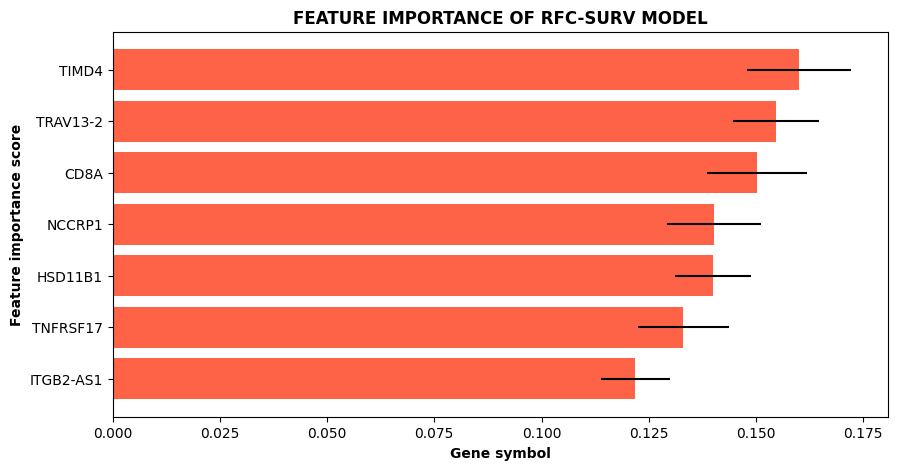

In [100]:
# TRỰC QUAN HÓA KẾT QUẢ FEATURE IMPORTANCE
utils.feature_importance_graph(df_feature_rfc_surv_final,'FEATURE IMPORTANCE OF RFC-SURV MODEL')

## 8.2.RFC-SEQ

In [20]:
def gene_filtered_dataframe(df:pd.DataFrame,dict_seleceted_gene:dict)->pd.DataFrame:
    list_gene_in_df=df.columns
    # TRƯỜNG HỢP DATAFRAME CÓ CỘT LÀ GENE ID: DIGIT
    if all(list(map(lambda x:x.isdigit(),list_gene_in_df))):
        df=df.loc[::,df.columns.isin(dict_seleceted_gene.keys())]
        df.rename(columns=dict_seleceted_gene,inplace=True)
    # TRƯỜNG HỢP DATAFRAME CÓ CỘT LÀ GENE SYMBOL
    else:
        df=df.loc[::,df.columns.isin(dict_seleceted_gene.values())]
    return df

#### 8.2.1.CHUẨN BỊ DỮ LIỆU 

In [103]:
dict_up_and_down_genes=utils.gene_dict_id_symbol(top_4_down+top_4_up)
dict_up_and_down_genes

Input sequence provided is already in string format. No operation performed


{'100505746': 'ITGB2-AS1',
 '574028': 'CLLU1',
 '654817': 'NCF1C',
 '9288': 'TAAR3P',
 '353133': 'LCE1C',
 '444882': 'IGFL4',
 '56146': 'PCDHA2',
 '8988': 'HSPB3'}

In [104]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE78220
df_gse78220_rfc_seq=df_gse78220_normalized.loc[::,df_gse78220_normalized.columns.isin(dict_up_and_down_genes.values())]
df_gse78220_rfc_seq

,CLLU1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCF1C,PCDHA2
Pt1.baseline,0.031134,0.000000,1.926175,1.324825,0.000000,2.227675,1.721915e-02
Pt10.baseline,0.023754,0.146611,0.240910,0.322398,0.000000,2.016740,2.554450e-02
Pt12.baseline,0.016320,0.000000,6.661575,0.185412,0.043712,0.558847,3.163405e-44
Pt13.baseline,0.009076,0.000000,0.565820,1.090100,0.000000,5.745260,5.728740e-02
Pt14.baseline,0.017398,0.055231,0.063708,1.051490,0.028750,3.263695,9.105350e-03
Pt15.baseline,0.017010,2.058855,0.790077,1.823070,0.000000,4.330925,2.776550e-01
Pt16.OnTx,0.041516,0.000000,0.000000,0.322519,0.000000,7.717720,2.386900e-31
Pt19.baseline,0.121219,5.411515,0.119415,0.506889,0.000000,8.108240,1.794970e-23
Pt2.baseline,0.000000,0.046564,0.668588,0.818914,0.000000,4.809975,7.592816e-23
Pt20.baseline,0.012530,0.050482,0.000000,4.971495,0.000000,25.811550,1.233295e+00


In [105]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE91061
df_gse91061_normalized_rfc_seq=df_gse91061_normalized.loc[::,df_gse91061_normalized.columns.isin(dict_up_and_down_genes.keys())]
# ĐỔI TÊN GENE ID THÀNH GENE SYMBOL
df_gse91061_normalized_rfc_seq.rename(columns=dict_up_and_down_genes,inplace=True)
df_gse91061_normalized_rfc_seq

,ITGB2-AS1,LCE1C,IGFL4,PCDHA2,CLLU1,NCF1C,HSPB3,TAAR3P
Pt101_On_AD681975-5,9.725053,-1.444638,1.902541,1.035786,8.419779,10.030411,0.215859,-0.719818
Pt101_Pre_AD486328-5,9.244326,-1.311949,0.330398,1.063072,8.789311,11.536380,0.252421,-0.705124
Pt103_On_AE134059-6,5.532511,9.028036,2.373624,1.872334,3.617541,7.022998,1.854873,0.272620
Pt103_Pre_AE134058-2,9.005670,8.767246,0.496285,3.924143,5.441278,9.749929,4.172758,-0.649201
Pt105_On_AE373241-6,6.210693,-1.319089,0.327733,1.061530,4.096715,7.711705,0.250375,7.653572
...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,6.292089,-1.117803,0.406390,1.108352,4.282924,7.255980,0.311374,-0.680844
Pt98_On_AE086717-6,5.643992,-1.256759,0.351318,4.907566,0.911832,7.659717,3.884349,-0.698559
Pt98_Pre_AD733586-8,4.690230,-1.215408,0.367352,4.594762,2.298259,7.143329,4.772450,-0.693464
Pt9_On_E9047644-7,4.860693,-1.420400,3.452616,4.996088,2.776997,7.029241,8.120946,-0.717248


In [106]:
# KÊT HỢP 2 BỘ DATA GSE78220 VÀ GSE91061
X_rfc_seq=pd.concat([df_gse78220_rfc_seq,df_gse91061_normalized_rfc_seq],axis=0)
X_rfc_seq

,CLLU1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCF1C,PCDHA2,TAAR3P
Pt1.baseline,0.031134,0.000000,1.926175,1.324825,0.000000,2.227675,1.721915e-02,NaN
Pt10.baseline,0.023754,0.146611,0.240910,0.322398,0.000000,2.016740,2.554450e-02,NaN
Pt12.baseline,0.016320,0.000000,6.661575,0.185412,0.043712,0.558847,3.163405e-44,NaN
Pt13.baseline,0.009076,0.000000,0.565820,1.090100,0.000000,5.745260,5.728740e-02,NaN
Pt14.baseline,0.017398,0.055231,0.063708,1.051490,0.028750,3.263695,9.105350e-03,NaN
...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,4.282924,0.311374,0.406390,6.292089,-1.117803,7.255980,1.108352e+00,-0.680844
Pt98_On_AE086717-6,0.911832,3.884349,0.351318,5.643992,-1.256759,7.659717,4.907566e+00,-0.698559
Pt98_Pre_AD733586-8,2.298259,4.772450,0.367352,4.690230,-1.215408,7.143329,4.594762e+00,-0.693464
Pt9_On_E9047644-7,2.776997,8.120946,3.452616,4.860693,-1.420400,7.029241,4.996088e+00,-0.717248


In [107]:
y_rfc_seq=pd.concat([df_meta_GSE78220['New_conditions_encoded'],df_meta_GSE91061['New_conditions_encoded']])
y_rfc_seq

Pt1                    0
Pt10                   0
Pt12                   0
Pt13                   1
Pt14                   0
                      ..
Pt94_Pre_AD732850-6    0
Pt98_On_AE086717-6     1
Pt98_Pre_AD733586-8    1
Pt9_On_E9047644-7      1
Pt9_Pre_E9021024-6     1
Name: New_conditions_encoded, Length: 133, dtype: int64

In [108]:
# CHIA TẬP TRAINING VÀ TESTING
X_train_rfc_seq,X_test_rfc_seq,y_train_rfc_seq,y_test_rfc_seq=train_test_split(X_rfc_seq,
                                                                                   y_rfc_seq,
                                                                                   random_state=42,
                                                                                   train_size=0.8,
                                                                                   stratify=y_rfc_seq)

#### 8.2.2.TRAIN MÔ HÌNH

In [111]:
# CROSS VADIATION MÔ HÌNH RFC-SEQ
cross_validation_rfc_seq=utils.cross_validation_by_RFC(10,X_train_rfc_seq,y_train_rfc_seq,'accuracy',42)
cross_validation_rfc_seq

array([0.63636364, 0.90909091, 0.72727273, 0.72727273, 0.81818182,
       0.72727273, 0.8       , 0.9       , 0.7       , 0.7       ])

In [113]:
df_score_rfc_seq,df_feature_rfc_seq=utils.training_RFC(X_train_rfc_seq,y_train_rfc_seq,X_test_rfc_seq,y_test_rfc_seq,100)

In [118]:
# METRICS MÔ HÌNH RFC-SEQ
df_score_rfc_seq

,accuracy_test,accuracy_train,recall,precison,f1
0,0.814815,1.0,0.80,0.941176,0.864865
1,0.851852,1.0,0.85,0.944444,0.894737
2,0.814815,1.0,0.80,0.941176,0.864865
3,0.777778,1.0,0.75,0.937500,0.833333
4,0.851852,1.0,0.85,0.944444,0.894737
...,...,...,...,...,...
95,0.777778,1.0,0.75,0.937500,0.833333
96,0.814815,1.0,0.80,0.941176,0.864865
97,0.777778,1.0,0.80,0.888889,0.842105
98,0.814815,1.0,0.80,0.941176,0.864865


In [117]:
# FEATURE IMPORTANCE MÔ HÌNH RFC-SEQ
df_feature_rfc_seq

,CLLU1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCF1C,PCDHA2,TAAR3P
0,0.145532,0.093876,0.132891,0.095737,0.074022,0.121048,0.161787,0.175107
1,0.140310,0.096364,0.131632,0.103649,0.076789,0.142005,0.135102,0.174148
2,0.162963,0.104152,0.142132,0.085788,0.089513,0.116643,0.132880,0.165930
3,0.153363,0.111564,0.110478,0.093375,0.077516,0.143254,0.149109,0.161343
4,0.140665,0.099508,0.111595,0.088690,0.092815,0.152322,0.155602,0.158803
...,...,...,...,...,...,...,...,...
95,0.160628,0.097245,0.115773,0.090919,0.083513,0.129900,0.164076,0.157945
96,0.181472,0.090150,0.125091,0.106112,0.071430,0.130089,0.157674,0.137983
97,0.160809,0.095875,0.131100,0.093716,0.075742,0.120778,0.155069,0.166910
98,0.137525,0.090300,0.119263,0.093658,0.082336,0.143080,0.172452,0.161386


#### 8.2.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [151]:
print(f'Kết quả cross-validation của mô hình RFC-SURV: {cross_validation_rfc_seq.mean():.4f}±{cross_validation_rfc_seq.std():.4f}')

Kết quả cross-validation của mô hình RFC-SURV: 0.7645±0.0850


In [124]:
#BẢN KẾT QUẢ METRICS
df_score_rfc_seq_final=utils.caculate_result(df_score_rfc_seq)
df_score_rfc_seq_final

,mean,std
accuracy_test,0.820370,0.035849
accuracy_train,1.000000,0.000000
recall,0.820500,0.044435
precison,0.929291,0.024148
f1,0.870758,0.027815


In [127]:
#BẢN KẾT QUẢ FEATURE IMPORANTANCE
df_feature_rfc_seq_final=utils.caculate_result(df_feature_rfc_seq)
df_feature_rfc_seq_final.sort_values(by='mean',inplace=True,ascending=True)
df_feature_rfc_seq_final

,mean,std
LCE1C,0.079113,0.006955
ITGB2-AS1,0.100751,0.008133
HSPB3,0.101770,0.008578
IGFL4,0.117374,0.009809
NCF1C,0.134043,0.010428
PCDHA2,0.152295,0.010845
TAAR3P,0.156363,0.010803
CLLU1,0.158292,0.010291


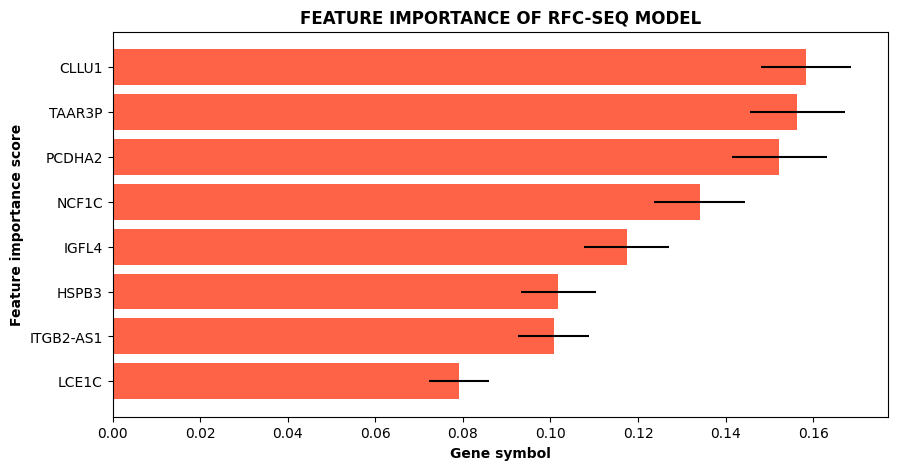

In [128]:
utils.feature_importance_graph(df_feature_rfc_seq_final,'FEATURE IMPORTANCE OF RFC-SEQ MODEL')

## 8.3.RFC-16

#### 8.3.1.CHUẨN BỊ DỮ LIỆU 

In [131]:
dict_gene_16=dict_up_and_down_genes.copy()
dict_gene_16.update(dict_top_8_gene)
dict_gene_16

{'100505746': 'ITGB2-AS1',
 '574028': 'CLLU1',
 '654817': 'NCF1C',
 '9288': 'TAAR3P',
 '353133': 'LCE1C',
 '444882': 'IGFL4',
 '56146': 'PCDHA2',
 '8988': 'HSPB3',
 '925': 'CD8A',
 '3290': 'HSD11B1',
 '342897': 'NCCRP1',
 '91937': 'TIMD4',
 '608': 'TNFRSF17',
 '28670': 'TRAV13-2'}

In [133]:
df_gse78220_rfc_16=utils.gene_filtered_dataframe(df_gse78220_normalized,dict_gene_16)
df_gse78220_rfc_16

,CD8A,CLLU1,HSD11B1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCCRP1,NCF1C,PCDHA2,TIMD4,TNFRSF17
Pt1.baseline,7.000980,0.031134,3.871880,0.000000,1.926175,1.324825,0.000000,0.103352,2.227675,1.721915e-02,1.717475,1.229935
Pt10.baseline,0.852225,0.023754,2.524035,0.146611,0.240910,0.322398,0.000000,0.031969,2.016740,2.554450e-02,0.025166,0.000000
Pt12.baseline,0.424683,0.016320,5.329545,0.000000,6.661575,0.185412,0.043712,0.037742,0.558847,3.163405e-44,0.094384,0.027566
Pt13.baseline,25.246950,0.009076,4.797695,0.000000,0.565820,1.090100,0.000000,0.147132,5.745260,5.728740e-02,0.639527,0.291212
Pt14.baseline,3.674290,0.017398,2.946015,0.055231,0.063708,1.051490,0.028750,0.046271,3.263695,9.105350e-03,0.766837,0.042425
Pt15.baseline,10.995700,0.017010,0.508158,2.058855,0.790077,1.823070,0.000000,0.163296,4.330925,2.776550e-01,0.290699,1.527530
Pt16.OnTx,2.647070,0.041516,1.764710,0.000000,0.000000,0.322519,0.000000,1.634550,7.717720,2.386900e-31,0.000000,0.217395
Pt19.baseline,9.030915,0.121219,0.988278,5.411515,0.119415,0.506889,0.000000,0.150637,8.108240,1.794970e-23,0.249476,0.547161
Pt2.baseline,9.691270,0.000000,164.842000,0.046564,0.668588,0.818914,0.000000,0.067927,4.809975,7.592816e-23,5.431415,0.128545
Pt20.baseline,109.778500,0.012530,9.045125,0.050482,0.000000,4.971495,0.000000,0.765850,25.811550,1.233295e+00,0.357466,37.044300


In [134]:
df_gse91061_normalized_rfc_16=utils.gene_filtered_dataframe(df_gse91061_normalized,dict_gene_16)
df_gse91061_normalized_rfc_16

,ITGB2-AS1,TRAV13-2,HSD11B1,NCCRP1,LCE1C,IGFL4,PCDHA2,CLLU1,TNFRSF17,NCF1C,HSPB3,TIMD4,CD8A,TAAR3P
Pt101_On_AD681975-5,9.725053,5.822927,8.338059,5.413379,-1.444638,1.902541,1.035786,8.419779,8.603622,10.030411,0.215859,9.656047,11.377792,-0.719818
Pt101_Pre_AD486328-5,9.244326,6.017326,8.570024,6.458157,-1.311949,0.330398,1.063072,8.789311,8.769242,11.536380,0.252421,9.747960,11.328933,-0.705124
Pt103_On_AE134059-6,5.532511,2.755570,6.775924,8.549315,9.028036,2.373624,1.872334,3.617541,3.483469,7.022998,1.854873,2.726851,7.635343,0.272620
Pt103_Pre_AE134058-2,9.005670,4.496137,8.497873,9.214753,8.767246,0.496285,3.924143,5.441278,8.163234,9.749929,4.172758,4.823249,10.936760,-0.649201
Pt105_On_AE373241-6,6.210693,4.786366,9.427359,4.073086,-1.319089,0.327733,1.061530,4.096715,5.968032,7.711705,0.250375,6.871137,11.907791,7.653572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,6.292089,3.587451,7.519322,4.302166,-1.117803,0.406390,1.108352,4.282924,5.946053,7.255980,0.311374,7.004949,9.424188,-0.680844
Pt98_On_AE086717-6,5.643992,4.476089,7.568341,6.066942,-1.256759,0.351318,4.907566,0.911832,4.448721,7.659717,3.884349,4.483002,10.164901,-0.698559
Pt98_Pre_AD733586-8,4.690230,1.731532,6.396133,5.924993,-1.215408,0.367352,4.594762,2.298259,4.122981,7.143329,4.772450,2.383578,7.526615,-0.693464
Pt9_On_E9047644-7,4.860693,1.255144,4.710765,3.461268,-1.420400,3.452616,4.996088,2.776997,1.715957,7.029241,8.120946,3.383643,8.367420,-0.717248


In [136]:
X_rfc_16=pd.concat([df_gse78220_rfc_16,df_gse91061_normalized_rfc_16])
X_rfc_16

,CD8A,CLLU1,HSD11B1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCCRP1,NCF1C,PCDHA2,TIMD4,TNFRSF17,TRAV13-2,TAAR3P
Pt1.baseline,7.000980,0.031134,3.871880,0.000000,1.926175,1.324825,0.000000,0.103352,2.227675,1.721915e-02,1.717475,1.229935,NaN,NaN
Pt10.baseline,0.852225,0.023754,2.524035,0.146611,0.240910,0.322398,0.000000,0.031969,2.016740,2.554450e-02,0.025166,0.000000,NaN,NaN
Pt12.baseline,0.424683,0.016320,5.329545,0.000000,6.661575,0.185412,0.043712,0.037742,0.558847,3.163405e-44,0.094384,0.027566,NaN,NaN
Pt13.baseline,25.246950,0.009076,4.797695,0.000000,0.565820,1.090100,0.000000,0.147132,5.745260,5.728740e-02,0.639527,0.291212,NaN,NaN
Pt14.baseline,3.674290,0.017398,2.946015,0.055231,0.063708,1.051490,0.028750,0.046271,3.263695,9.105350e-03,0.766837,0.042425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,9.424188,4.282924,7.519322,0.311374,0.406390,6.292089,-1.117803,4.302166,7.255980,1.108352e+00,7.004949,5.946053,3.587451,-0.680844
Pt98_On_AE086717-6,10.164901,0.911832,7.568341,3.884349,0.351318,5.643992,-1.256759,6.066942,7.659717,4.907566e+00,4.483002,4.448721,4.476089,-0.698559
Pt98_Pre_AD733586-8,7.526615,2.298259,6.396133,4.772450,0.367352,4.690230,-1.215408,5.924993,7.143329,4.594762e+00,2.383578,4.122981,1.731532,-0.693464
Pt9_On_E9047644-7,8.367420,2.776997,4.710765,8.120946,3.452616,4.860693,-1.420400,3.461268,7.029241,4.996088e+00,3.383643,1.715957,1.255144,-0.717248


In [139]:
y_rfc_16=pd.concat([df_meta_GSE78220['New_conditions_encoded'],df_meta_GSE91061['New_conditions_encoded']])
y_rfc_16

Pt1                    0
Pt10                   0
Pt12                   0
Pt13                   1
Pt14                   0
                      ..
Pt94_Pre_AD732850-6    0
Pt98_On_AE086717-6     1
Pt98_Pre_AD733586-8    1
Pt9_On_E9047644-7      1
Pt9_Pre_E9021024-6     1
Name: New_conditions_encoded, Length: 133, dtype: int64

In [141]:
X_train_rfc_16,X_test_rfc_16,y_train_rfc_16,y_test_rfc_16=train_test_split(X_rfc_16,
                                                                           y_rfc_16,
                                                                           random_state=42,
                                                                           stratify=y_rfc_16,
                                                                           train_size=0.8)

#### 8.3.2.TRAIN MÔ HÌNH

In [143]:
cross_validation_rfc_16=utils.cross_validation_by_RFC(10,X_train_rfc_16,y_train_rfc_16,'accuracy',seed=42)
cross_validation_rfc_16

array([0.63636364, 0.90909091, 0.72727273, 0.72727273, 0.81818182,
       0.72727273, 0.8       , 0.9       , 0.5       , 0.6       ])

In [144]:
df_score_rfc_16,df_feature_rfc_16=utils.training_RFC(X_train_rfc_16,y_train_rfc_16,X_test_rfc_16,y_test_rfc_16,100)

#### 8.3.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [150]:
print(f'Kết quả cross-validation của mô hình RFC-SURV: {cross_validation_rfc_16.mean():.4f}±{cross_validation_rfc_16.std():.4f}')

Kết quả cross-validation của mô hình RFC-SURV: 0.7345±0.1233


In [146]:
df_score_rfc_16_final=utils.caculate_result(df_score_rfc_16)
df_score_rfc_16_final

,mean,std
accuracy_test,0.842593,0.022566
accuracy_train,1.000000,0.000000
recall,0.840000,0.024618
precison,0.941244,0.013615
f1,0.887573,0.016936


In [148]:
df_feature_rfc_16_final=utils.caculate_result(df_feature_rfc_16)
df_feature_rfc_16_final.sort_values(by='mean',inplace=True,ascending=True)
df_feature_rfc_16_final

,mean,std
LCE1C,0.037461,0.005263
ITGB2-AS1,0.053929,0.006831
HSPB3,0.058328,0.006826
IGFL4,0.064565,0.007617
NCCRP1,0.064848,0.007410
TNFRSF17,0.064937,0.007459
NCF1C,0.068429,0.007404
CD8A,0.072012,0.008889
HSD11B1,0.072301,0.007276
TRAV13-2,0.079279,0.008861


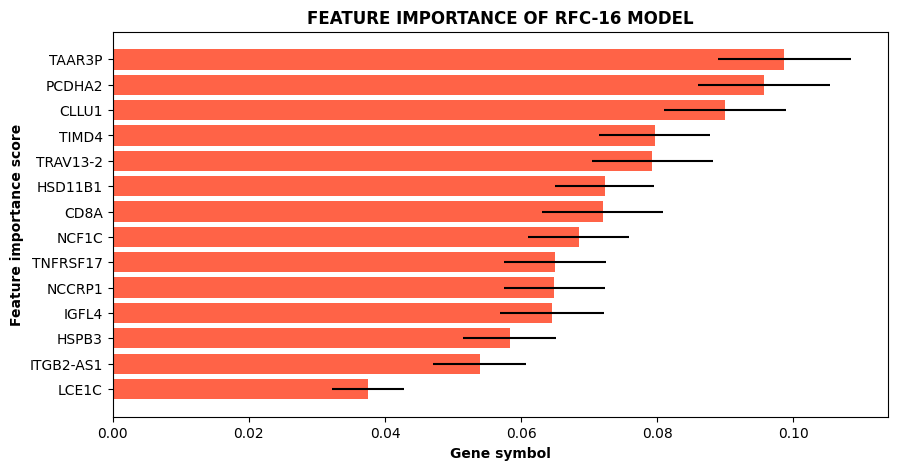

In [149]:
utils.feature_importance_graph(df_feature_rfc_16_final,'FEATURE IMPORTANCE OF RFC-16 MODEL')